In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

animal = 'BS_100'

ops_directory = 'D:\\OpsinTest_Cache'
beh_directory = 'Z:\\Behavioor'


stdfont = 14
stdyfrac = 0.06

In [2]:
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(ops_directory)

numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.task not in ['opto nonreversal','opto switch','opto reversal']:
        continue


    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass

print('M2       : ' + str(numM2))

100%|██████████| 5/5 [00:00<00:00, 97.81it/s]

M2       : 29


In [3]:
M2_sessions = np.unique(EnumM2Session)

In [4]:
M2_sessions

array(['BS_100_1002_opto_M2.pickle', 'BS_100_1003_opto_M2.pickle',
       'BS_100_1004_opto_M2.pickle', 'BS_100_101_opto_M2.pickle',
       'BS_100_102_opto_M2.pickle'], dtype='<U26')

In [5]:
 sessionfile.responsiveness[clust]['laser_on'].FRmodulation

1.8415637860082292

In [6]:
 sessionfile.responsiveness[clust]['laser_off'].FRmodulation

1.5535714285714288

In [131]:
len(EnumM2Clust)

29

In [7]:
FRmod = []
FRmod_On = []
FRmod_Off = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        print(clust)
        FRmod_clust = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        FRmod_On_clust = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
        FRmod_Off_clust = sessionfile.responsiveness[clust]['laser_off'].FRmodulation
        
        FRmod.append(FRmod_clust)
        FRmod_On.append(FRmod_On_clust)
        FRmod_Off.append(FRmod_Off_clust)
        
    except Exception as e:
        FRmod = np.nan
        
    
    
    

29it [00:00, 223.35it/s]

70
110
149
6
48
56
59
61
62
88
0
162
164
167
171
6
36
39
59
60
78
115
118
90
104
107
124
160
167


In [8]:
FRmod_On = np.array(FRmod_On)
FRmod_Off = np.array(FRmod_Off)

In [9]:
FRmod_On

array([ 1.8081761 ,  4.49685535,  4.79559748,  2.32371795,  1.5224359 ,
        0.51282051,  2.58012821,  2.51602564,  7.61217949,  2.05128205,
        0.34013605,  2.4829932 ,  2.97619048, 17.17687075,  1.61564626,
        2.40918803, 12.40384615,  2.35042735,  2.7457265 , 22.78846154,
        3.50282486,  6.34615385, 13.37606838,  6.40957447,  3.71175523,
        5.40084388,  5.50925926,  0.72435897,  1.84156379])

In [10]:
FRmod_Off

array([ 2.67730496,  6.32978723,  7.78368794,  2.36111111,  2.08333333,
        0.98958333,  3.19444444,  1.44097222,  3.28125   ,  2.36111111,
        0.4248366 ,  2.54901961,  1.45424837, 13.23529412,  2.15686275,
       10.08680556, 25.88541667,  0.6712963 , 14.34027778, 26.22106481,
        2.8978979 ,  9.13194444, 21.24421296,  8.13218391,  4.22279793,
        6.54761905,  3.02631579,  1.59214092,  1.55357143])

meta NOT subset; don't know how to subset; dropped


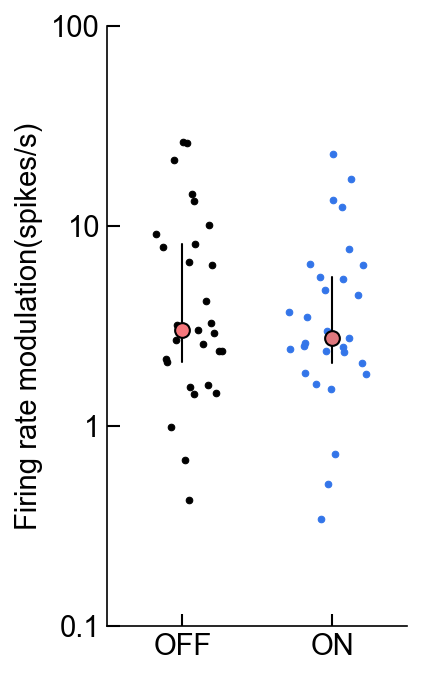

In [11]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
size=10

################################################################################################################

data_on =FRmod_On
data_off = FRmod_Off

labels = ['OFF','ON']
numCon = 2

wid = 0.75
widsc = wid/1.75#*1.125

X = np.ones_like(data_off)*0
_,Y = ilep.violin(X,data_off,width=wid,minjitter=0.075)
X,_ = ilep.violin(X,np.log10(data_off),width=wid,minjitter=0.075)
#X -= widsc
ax.scatter(X, Y, s=size, c='black', lw=0.5,zorder=-10,label='Laser OFF')

X = np.ones_like(data_on)*1
_,Y = ilep.violin(X,data_on,width=wid,minjitter=0.075)
X,_ = ilep.violin(X,np.log10(data_on),width=wid,minjitter=0.075)
#X += widsc
ax.scatter(X, Y, s=size, c=LASER_COLOR, lw=0.5,zorder=-10,label='Laser ON')


######################################

FRmod_baseline_median = 3.5
column = data_off
column = ilep.rmnan(column)
percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
eye_color= NCR_CR_cmap((percentCR-40)/20)
border_color = 'k'#eye_color

summary_size=50
summary_width=1

Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
ax.scatter([0], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
ax.plot([0,0], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


column = data_on
column = ilep.rmnan(column)
percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
eye_color= NCR_CR_cmap((percentCR-40)/20)
border_color = 'k'#eye_color

summary_size=50
summary_width=1

Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
ax.scatter([1], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
ax.plot([1,1], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

################################################################################################################

labels = ['OFF','ON']

ax.set_ylim([0,100])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,1.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

artists = [ylab]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\BS opsin test firing rate modulation.pdf'),transparent=False,facecolor="white", bbox_inches='tight')

In [12]:
sessionfile.responsiveness[clust]['laser_on'].trials

array([  1,   3,   4,   5,   8,  12,  15,  16,  18,  19,  21,  23,  24,
        26,  27,  29,  31,  35,  36,  38,  41,  42,  43,  44,  46,  52,
        53,  54,  55,  56,  58,  59,  63,  64,  65,  66,  67,  68,  72,
        73,  74,  77,  83,  85,  88,  90,  91,  92,  94,  97,  98,  99,
       102, 105, 107, 108, 110, 112, 113, 114, 116, 118, 119, 121, 123,
       125, 126, 127, 128, 129, 131, 132, 136, 139, 142, 145, 146, 147,
       148, 149, 150, 151, 155, 156, 158, 160, 163, 164, 165, 167, 170,
       174, 175, 176, 177, 179, 180, 181, 184, 188, 189, 191, 192, 195,
       198, 199, 202, 203, 205, 206, 208, 209, 210, 211, 212, 218, 221,
       223, 225, 228, 229, 232, 234, 235, 236, 237, 238, 241, 242, 243,
       244, 245, 246, 252, 253, 255, 257, 258, 259, 260, 261, 262, 263,
       268, 269, 270, 273, 274, 275, 278, 279, 283, 284, 290, 291, 292,
       293, 294, 298, 299, 300, 301])

In [13]:
sessionfile.meta.fs

30000

In [14]:
sessionfile.trials.starts

array([   62675.,   180466.,   271631.,   362684.,   454153.,   590694.,
         691967.,   912138.,  1132534.,  1234909.,  1457817.,  1678390.,
        1829685.,  2051685.,  2271881.,  2492491.,  2604419.,  2695519.,
        2916200.,  3019867.,  3120265.,  3262374.,  3363022.,  3583314.,
        3674914.,  3766509.,  3987065.,  4087757.,  4308186.,  4399945.,
        4500586.,  4720990.,  4821578.,  4912918.,  5004378.,  5121419.,
        5222068.,  5443003.,  5663426.,  5889383.,  5980967.,  6072332.,
        6163990.,  6255348.,  6476354.,  6567935.,  6659472.,  6750832.,
        6842714.,  7063330.,  7283930.,  7375490.,  7466879.,  7558326.,
        7649566.,  7741161.,  7961324.,  8052921.,  8144365.,  8235847.,
        8327544.,  8419167.,  8510665.,  8602162.,  8693492.,  8785015.,
        8876403.,  8967972.,  9059375.,  9150634.,  9242269.,  9333908.,
        9425386.,  9516655.,  9608241.,  9699855.,  9791293.,  9882546.,
        9973801., 10065154., 10156460., 10247705., 

In [19]:
sessionfile1001 = ilep.loadSessionCached(ops_directory,M2_sessions[3])
sessionfile1002 = ilep.loadSessionCached(ops_directory,M2_sessions[0])
sessionfile1003 = ilep.loadSessionCached(ops_directory,M2_sessions[1])
sessionfile1004 = ilep.loadSessionCached(ops_directory,M2_sessions[2])
sessionfile2001 = ilep.loadSessionCached(ops_directory,M2_sessions[4])

In [20]:
M2_sessions[0]

'BS_100_1002_opto_M2.pickle'

In [21]:
M2_sessions[1]

'BS_100_1003_opto_M2.pickle'

In [22]:
M2_sessions[2]

'BS_100_1004_opto_M2.pickle'

In [23]:
M2_sessions[3]

'BS_100_101_opto_M2.pickle'

In [24]:
M2_sessions[4]

'BS_100_102_opto_M2.pickle'

In [26]:
sessionfile1001.clusters.good

array([  6,  36,  39,  59,  60,  78, 115, 118], dtype=int64)

In [27]:
sessionfile1002.clusters.good

array([ 70, 110, 149], dtype=int64)

In [28]:
sessionfile1003.clusters.good

array([ 6, 48, 56, 59, 61, 62, 88], dtype=int64)

In [29]:
sessionfile1004.clusters.good

array([  0, 162, 164, 167, 171], dtype=int64)

In [30]:
sessionfile2001.clusters.good

array([ 90, 104, 107, 124, 160, 167], dtype=int64)

### check tone and laser time

In [41]:
sessionfile1001 = ilep.loadSessionCached(ops_directory,M2_sessions[3])
sessionfile1002 = ilep.loadSessionCached(ops_directory,M2_sessions[0])
sessionfile1003 = ilep.loadSessionCached(ops_directory,M2_sessions[1])
sessionfile1004 = ilep.loadSessionCached(ops_directory,M2_sessions[2])
sessionfile2001 = ilep.loadSessionCached(ops_directory,M2_sessions[4])

In [42]:
S1001_tone_times = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1\\tone_times.npy') #same as sessionfile.trials.starts
S1001_tone_IDs = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1\\tone_IDs.npy')
S1001_laser_events = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1\\laser_events.npy')

S1002_tone_times = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1002\\tone_times.npy')
S1002_tone_IDs = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1002\\tone_IDs.npy')
S1002_laser_events = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1002\\laser_events.npy')

S1003_tone_times = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1003\\tone_times.npy')
S1003_tone_IDs = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1003\\tone_IDs.npy')
S1003_laser_events = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1003\\laser_events.npy')

S1004_tone_times = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1004\\tone_times.npy')
S1004_tone_IDs = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1004\\tone_IDs.npy')
S1004_laser_events = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1004\\laser_events.npy')

S2_tone_times = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 2\\tone_times.npy') #same as sessionfile.trials.starts
S2_tone_IDs = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 2\\tone_IDs.npy')
S2_laser_events = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 2\\laser_events.npy')

In [70]:
S1001_laser_start = []
S1001_laser_end = []
S1002_laser_start = []
S1002_laser_end = []
S1003_laser_start = []
S1003_laser_end = []
S1004_laser_start = []
S1004_laser_end = []

for idx,time in enumerate(S1001_laser_events[0]):
    if idx%2 == 0:
        S1001_laser_start.append(time)
    else:
        S1001_laser_end.append(time)

S1002_laser_start = []
S1002_laser_end = []
for idx,time in enumerate(S1002_laser_events[0]):
    if idx%2 == 0:
        S1002_laser_start.append(time)
    else:
        S1002_laser_end.append(time)

S1003_laser_start = []
S1003_laser_end = []
for idx,time in enumerate(S1003_laser_events[0]):
    if idx%2 == 0:
        S1003_laser_start.append(time)
    else:
        S1003_laser_end.append(time)

S1004_laser_start = []
S1004_laser_end = []
for idx,time in enumerate(S1004_laser_events[0]):
    if idx%2 == 0:
        S1004_laser_start.append(time)
    else:
        S1004_laser_end.append(time)

S2_laser_start = []
S2_laser_end = []
for idx,time in enumerate(S2_laser_events[0]):
    if idx%2 == 0:
        S2_laser_start.append(time)
    else:
        S2_laser_end.append(time)
        

In [110]:
S1001_laser_end = np.array(S1001_laser_end)
S1001_laser_start = np.array(S1001_laser_start)
trials_on1001 = sessionfile1001.responsiveness[6]['laser_on'].trials

S1002_laser_end = np.array(S1002_laser_end)
S1002_laser_start = np.array(S1002_laser_start)
trials_on1002 = sessionfile1002.responsiveness[70]['laser_on'].trials

S1003_laser_end = np.array(S1003_laser_end)
S1003_laser_start = np.array(S1003_laser_start)
trials_on1003 = sessionfile1003.responsiveness[6]['laser_on'].trials

S1004_laser_end = np.array(S1004_laser_end)
S1004_laser_start = np.array(S1004_laser_start)
trials_on1004 = sessionfile1004.responsiveness[0]['laser_on'].trials

In [45]:
S2_laser_end = np.array(S2_laser_end)
S2_laser_start = np.array(S2_laser_start)
trials_on2001 = sessionfile2001.responsiveness[104]['laser_on'].trials

In [93]:
print(sessionfile1001.trials.starts[trials_on1001] - S1001_laser_start)
print(sessionfile1001.trials.starts - S1001_tone_times[0])
print(sessionfile1001.trials.starts[trials_on1001] - S1001_laser_end)

[50. 52. 52. 50. 50. 47. 52. 49. 49. 51. 53. 49. 49. 51. 49. 47. 48. 47.
 48. 50. 48. 51. 51. 55. 50. 51. 51. 51. 47. 49. 52. 48. 51. 49. 53. 51.
 50. 47. 50. 53. 49. 48. 51. 53. 50. 51. 54. 53. 52. 48. 50. 52. 55. 48.
 52. 47. 50. 48. 49. 50. 53. 50. 48. 54. 48. 47. 53. 50. 48. 51. 53. 49.
 50. 47. 53. 51. 50. 48. 51. 52. 51. 48. 52. 51. 52. 53. 48. 48. 46. 47.
 54. 52. 50. 48. 47. 53. 51. 50. 49. 50. 55. 50. 51. 47. 52. 50. 47. 52.
 52. 47. 50. 51. 48. 51. 52. 48. 48. 54. 49. 51. 47. 50. 49. 49. 55. 48.
 52. 51. 47. 47. 50. 47. 50. 49. 52. 49. 55. 48. 49. 49. 48. 49. 48. 49.
 48. 50. 51. 54. 49. 50. 51. 53. 49. 50. 48. 47.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

In [103]:
print(sessionfile1002.trials.starts[trials_on1002] - S1002_laser_start)
print(sessionfile1002.trials.starts - S1002_tone_times[0])
print(sessionfile1002.trials.starts[trials_on1002] - S1002_laser_end)

[32. 34. 36. 34. 34. 33. 32. 31. 36. 32. 36. 33. 30. 31. 34. 34. 30. 33.
 32. 36. 38. 31. 36. 36. 31. 33. 35. 35. 35. 33. 32. 36. 31. 37. 35. 31.
 32. 33. 33. 31. 34. 33. 32. 35. 32. 35. 35. 36. 32. 33. 31. 36. 33.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[-2961. -2963. -2962. -2966. -2965. -2955. -2963. -2963. -2962. -2967.
 -2957. -2966. -2962. -2965. -2963. -2962. -2960. -2966. -2966. -2962.
 -2959. -2957. -2961. -2963. -2967. -2964. -2960. -2958. -2962. -2959.
 -2961. -2960. -2966. -2959. -2958. -2967. -2965. -2967. -2964. -2964.
 -2962. -2965. -2960. -2959. -2965. -2962. -2965. -2956. -2965. -2961.
 -2964. -2962. -2964.]


In [111]:
print(sessionfile1003.trials.starts[trials_on1003] - S1003_laser_start)
print(sessionfile1003.trials.starts - S1003_tone_times[0])
print(sessionfile1003.trials.starts[trials_on1003] - S1003_laser_end)

[35. 37. 37. 34. 32. 34. 34. 36. 32. 31. 32. 33. 36. 32. 33. 33. 34. 33.
 34. 38. 33. 30. 33. 38. 35. 37. 32. 35. 34. 31. 33. 35. 36. 35. 31. 35.
 34. 31. 32. 31. 32. 34. 34. 37. 31. 35. 30. 31. 34. 33. 33. 34.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[-2963. -2958. -2960. -2966. -2968. -2958. -2962. -2961. -2957. -2963.
 -2967. -2967. -2952. -2964. -2962. -2964. -2954. -2961. -2964. -2960.
 -2964. -2967. -2960. -2960. -2964. -2961. -2957. -2965. -2961. -2969.
 -2959. -2962. -2964. -2964. -2961. -2964. -2963. -2966. -2966. -2964.
 -2966. -2955. -2958. -2962. -2962. -2960. -2970. -2968. -2962. -2967.
 -2964. -2966.]


In [112]:
print(sessionfile1004.trials.starts[trials_on1004] - S1004_laser_start)
print(sessionfile1004.trials.starts - S1004_tone_times[0])
print(sessionfile1004.trials.starts[trials_on1004] - S1004_laser_end)

[30. 33. 34. 37. 33. 32. 37. 31. 33. 32. 37. 33. 33. 36. 35. 32. 31. 36.
 32. 32. 38. 32. 32. 34. 35. 33. 34. 32. 35. 35. 31. 33. 33. 35. 30. 31.
 31. 35. 32. 30. 34. 34. 33. 34. 31. 32. 34. 34. 33.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[-2968. -2962. -2963. -2958. -2962. -2965. -2960. -2966. -2966. -2964.
 -2962. -2965. -2965. -2961. -2958. -2966. -2968. -2961. -2954. -2962.
 -2960. -2965. -2965. -2953. -2959. -2963. -2963. -2966. -2962. -2964.
 -2966. -2964. -2967. -2958. -2966. -2966. -2961. -2965. -2961. -2967.
 -2964. -2963. -2964. -2963. -2962. -2966. -2964. -2964. -2967.]


In [51]:
sessionfile2001.trials.starts[trials_on2001] - S2_laser_start

array([54., 53., 49., 52., 49., 50., 50., 50., 52., 54., 51., 47., 49.,
       46., 49., 47., 50., 48., 53., 50., 52., 52., 50., 52., 51., 51.,
       48., 52., 50., 52., 50., 53., 47., 53., 50., 51., 54., 48., 53.,
       47., 52., 51., 51., 50., 48., 54., 52., 53., 50., 52., 48., 50.,
       53., 51., 52., 52., 55., 55., 48., 48., 48., 48., 54., 52., 50.,
       49., 54., 51., 52., 47., 53., 49., 49., 52., 52., 50., 54., 51.,
       50., 51., 47., 54., 54., 51., 49., 53., 48., 50., 47., 52., 54.,
       49., 53., 53., 51., 49., 48., 47., 52., 48., 51., 54., 51., 47.,
       55., 53., 50., 49., 50., 51., 51., 49., 49., 52., 48., 49., 50.,
       47., 55., 51., 49., 52., 49., 49., 50., 50., 51., 53., 53., 49.,
       53., 52., 53., 52., 51., 52., 50., 50., 54., 51., 49., 54., 52.,
       53., 50., 53., 53., 50., 47., 49., 54., 46., 55., 51., 50., 54.,
       54., 51., 50., 49., 54., 50., 48., 53., 54., 48., 51., 49., 55.,
       52., 47., 49., 48., 48., 55., 46., 47., 52., 49., 48., 51

In [52]:
sessionfile2001.trials.starts - S2_tone_times[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [53]:
sessionfile2001.trials.starts[trials_on2001] - S2_laser_end

array([-2942., -2945., -2948., -2943., -2947., -2945., -2949., -2948.,
       -2944., -2945., -2946., -2941., -2951., -2947., -2946., -2953.,
       -2946., -2949., -2940., -2948., -2944., -2946., -2947., -2945.,
       -2946., -2946., -2944., -2941., -2948., -2942., -2948., -2941.,
       -2947., -2944., -2945., -2941., -2946., -2948., -2945., -2950.,
       -2944., -2949., -2945., -2943., -2951., -2946., -2943., -2942.,
       -2942., -2943., -2947., -2947., -2942., -2943., -2943., -2948.,
       -2945., -2943., -2944., -2952., -2943., -2952., -2941., -2947.,
       -2945., -2951., -2942., -2946., -2945., -2953., -2945., -2948.,
       -2945., -2944., -2947., -2948., -2941., -2947., -2949., -2949.,
       -2953., -2937., -2940., -2948., -2951., -2935., -2946., -2943.,
       -2946., -2946., -2942., -2944., -2946., -2943., -2947., -2946.,
       -2947., -2950., -2943., -2949., -2948., -2939., -2944., -2948.,
       -2943., -2938., -2944., -2947., -2948., -2947., -2937., -2949.,
      

In [113]:
30/30000*1000

1.0

In [114]:
50/30000*1000

1.6666666666666667

In [61]:
S1001_tone_durations = np.load('C:\\Users\insan\\Desktop\\BS 100\\tone_durations.npy')
S1002_tone_durations = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1002\\tone_durations.npy')
S1003_tone_durations = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1003\\tone_durations.npy')
S1004_tone_durations = np.load('S:\\Sorts\OpsinControls\\BS_100\\BS_100 1004\\tone_durations.npy')
S2001_tone_durations = np.load('C:\\Users\insan\\Desktop\\BS 100 2\\tone_durations.npy')

In [67]:
S1002_tone_durations/30000*1000

array([[100.96666667, 101.4       , 101.36666667, 101.4       ,
        101.43333333, 101.36666667, 101.13333333, 101.        ,
        101.6       , 101.4       , 101.33333333, 101.03333333,
        101.26666667, 101.33333333, 101.5       , 101.26666667,
        101.36666667, 101.43333333, 101.4       , 101.26666667,
        101.56666667, 101.33333333, 101.53333333, 101.2       ,
        101.6       , 101.36666667, 101.5       , 101.4       ,
        101.63333333, 101.6       , 101.33333333, 101.33333333,
        101.3       , 101.43333333, 101.53333333, 101.53333333,
        101.33333333, 101.5       , 101.56666667, 101.16666667,
        101.56666667, 101.56666667, 101.36666667, 101.23333333,
        101.23333333, 101.33333333, 101.26666667, 101.5       ,
        101.43333333, 101.3       , 101.33333333, 101.53333333,
        101.46666667, 101.26666667, 101.36666667, 101.4       ,
        101.26666667, 101.26666667, 101.23333333, 101.33333333,
        101.36666667, 101.43333333, 101.

In [69]:
S1003_tone_durations/30000*1000

array([[101.56666667, 101.4       , 101.26666667, 101.33333333,
        101.63333333, 101.43333333, 101.2       , 101.6       ,
        101.3       , 101.2       , 101.53333333, 101.3       ,
        101.43333333, 101.46666667, 101.36666667, 101.23333333,
        101.23333333, 101.43333333, 101.26666667, 101.43333333,
        101.6       , 101.5       , 101.43333333, 101.36666667,
        101.16666667, 101.03333333, 101.5       , 101.46666667,
        101.3       , 101.53333333, 101.33333333, 101.5       ,
        100.96666667, 101.4       , 101.43333333, 101.33333333,
        101.26666667, 101.43333333, 101.53333333, 101.46666667,
        101.33333333, 101.5       , 101.53333333, 101.4       ,
        101.26666667, 101.4       , 101.36666667, 101.16666667,
        101.33333333, 101.2       , 101.6       , 101.23333333,
        101.43333333, 101.26666667, 101.23333333, 101.56666667,
        101.6       , 101.16666667, 101.33333333, 101.33333333,
        101.36666667, 101.33333333, 101.

In [68]:
S1004_tone_durations/30000*1000

array([[101.53333333, 101.56666667, 101.56666667, 101.43333333,
        101.33333333, 101.5       , 101.33333333, 101.46666667,
        101.36666667, 101.13333333, 101.1       , 101.43333333,
        101.53333333, 101.5       , 101.33333333, 101.56666667,
        101.4       , 101.43333333, 101.6       , 101.26666667,
        101.46666667, 101.3       , 101.63333333, 101.13333333,
        101.36666667, 101.56666667, 101.53333333, 101.53333333,
        101.56666667, 101.33333333, 101.23333333, 101.2       ,
        101.5       , 101.53333333, 101.6       , 101.3       ,
        101.33333333, 101.13333333, 101.3       , 101.23333333,
        101.36666667, 101.4       , 101.36666667, 101.23333333,
        101.5       , 101.53333333, 101.4       , 101.03333333,
        101.23333333, 101.36666667, 101.5       , 101.33333333,
        101.56666667, 101.43333333, 101.5       , 101.56666667,
        101.3       , 101.        , 101.4       , 101.4       ,
        101.5       , 101.16666667, 101.

### Behavior

In [175]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


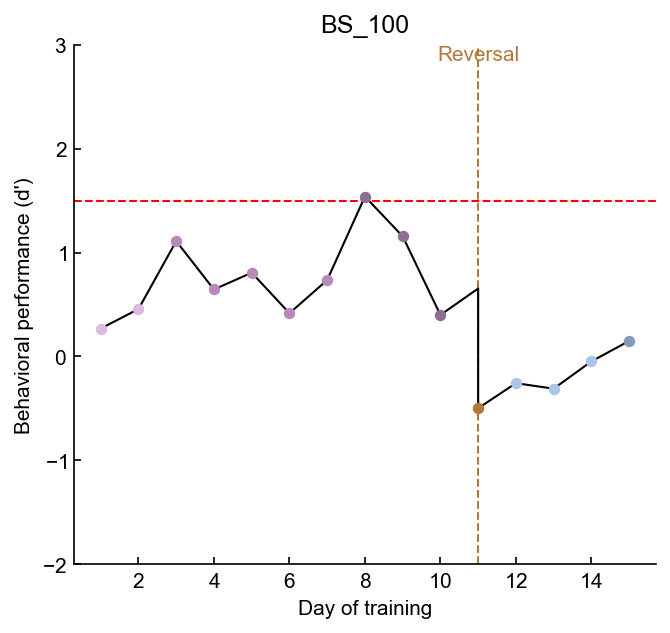

In [177]:
animalPhases,_,_ = ilep.calculateLearningPhasesV2(['BS_100'],animalBehaviors,plot=True)

### 5 recordings

In [129]:
def visualizeCluster(sessionfile,clust):

    bw_scott_factor = 3
    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.2)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

    # ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)
    # ax1.get_xaxis().set_visible(False)
    # ax1.get_yaxis().set_visible(False)
    
    tickmeans = []
    ticklabels = []
    ax1.set_ylabel('Trial')

    ax1.set_yticks(tickmeans)
    ax1.set_yticklabels(ticklabels)

    ax1.tick_params(axis='y',length=0)
    ax1.tick_params(axis='x',direction='out')
    ax1.set_xticks([-200,-100,0,100,200])
    #########################################################################################
    
    trialsToPlot_on = sessionfile.responsiveness[clust]['laser_on'].trials
    trialsToPlot_off = sessionfile.responsiveness[clust]['laser_off'].trials
    
    
    trialSpikes_on = []
    trialSpikes_off = []
    

    for trial in trialsToPlot_on:

        #Need to get spike times for each trail...
        starttime = sessionfile.trials.starts[trial]-0.3*sessionfile.meta.fs #-300ms
        endtime = starttime+0.6*sessionfile.meta.fs #-300+600=300ms
        
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - sessionfile.trials.starts[trial]

        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs #spikes in ms
        filtered_trialSpikes =  [n for n in this_trial_spikes if not (-2 <=n <=1 or 97.5 <=n <=101)]
        #filtered_trialSpikes = this_trial_spikes
        trialSpikes_on.append(filtered_trialSpikes)
    trialSpikes_on = np.array(trialSpikes_on,dtype='object')
    
    for trial in trialsToPlot_off:

        #Need to get spike times for each trail...
        starttime = sessionfile.trials.starts[trial]-0.3*sessionfile.meta.fs
        endtime = starttime+0.6*sessionfile.meta.fs
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - sessionfile.trials.starts[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs
        
        trialSpikes_off.append(this_trial_spikes)
    trialSpikes_off = np.array(trialSpikes_off,dtype='object')
     
    #On
    for idx,trial in enumerate(trialsToPlot_on):
        ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=LASER_COLOR,s=1.5,marker='o',lw=0)

    #Off
    ontrials = len(trialsToPlot_on)
    for idx,trial in enumerate(trialsToPlot_off):
        ax1.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx+ontrials,color='black',s=1.5,marker='o',lw=0)

    #Plot PSTH
    starttime = -300
    endtime = 300
    
    #On
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_on)):
        PSTHspikes = np.concatenate(trialSpikes_on[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_on = np.mean(FR,axis=0)
    sem_FR_on = np.std(FR,axis=0)

    #Off
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_off)):
        PSTHspikes = np.concatenate(trialSpikes_off[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_off = np.mean(FR,axis=0)
    sem_FR_off = np.std(FR,axis=0)
    
    max_FR_value_on = np.max(avg_FR_on+sem_FR_on) * 1.1
    max_FR_value_off = np.max(avg_FR_off+sem_FR_off) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    if max_FR_value_on > max_FR_value_off:
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_on)
    else:
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_off)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    
    
    ax2.plot(xrange,avg_FR_on,lw=2,color=LASER_COLOR,label='ON')
    ax2.plot(xrange,avg_FR_off,lw=2,color='black',label='OFF')
    
    #ax2.legend()
    
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    #laser line
    ax2.plot([0,100],[limit,limit],color='gray',lw=3,linestyle='-',zorder=10)
    ax2.text(35,limit+0.24,'Laser')
    ax2.set_xlim([-250,250])
    ax2.set_xticks([-200,-100,0,100,200])
    ax2.set_xticklabels(['-200','-100','0','100','200'])
    ax2.set_xlabel('Time (ms)')

    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\BS_5 recordings\\S1001 opsin'+ str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\BS_5 recordings\\S1002 opsin'+ str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\BS_5 recordings\\S1003 opsin'+ str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\BS_5 recordings\\S1004 opsin'+ str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\BS_5 recordings\\S2001 opsin'+ str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')

    
    return fig


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


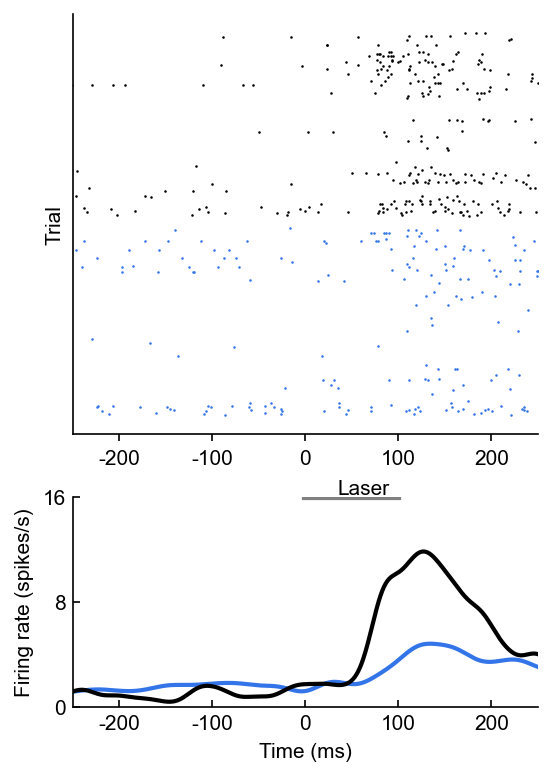

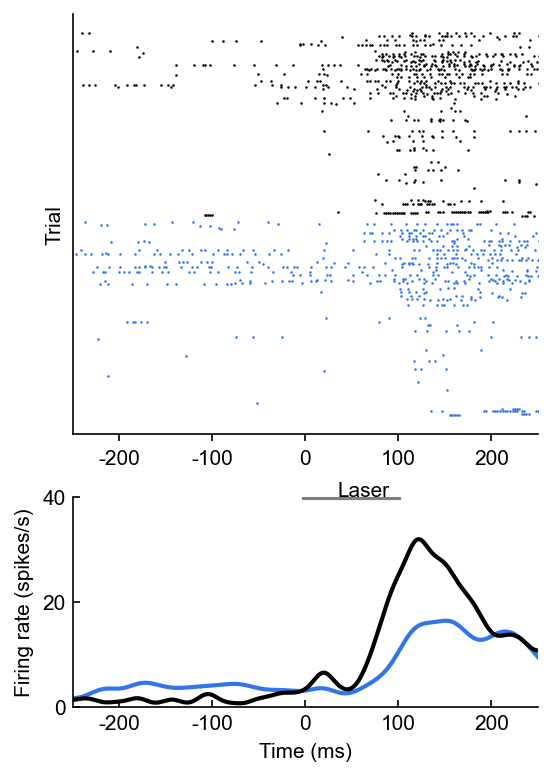

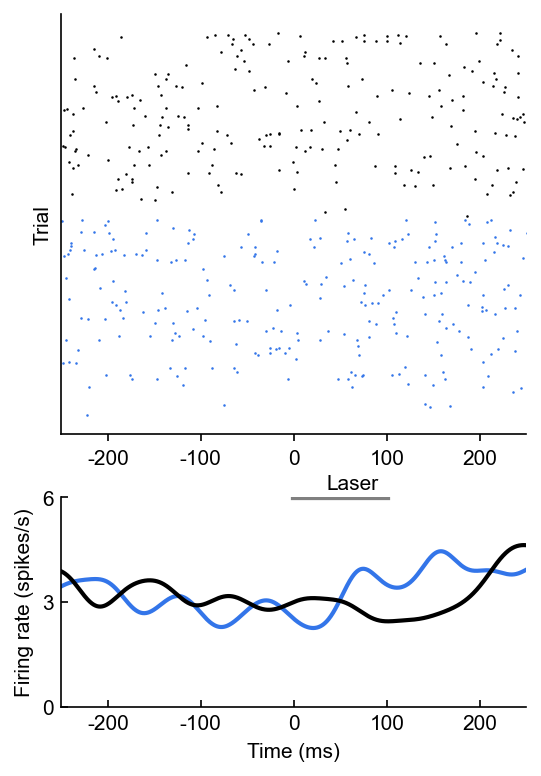

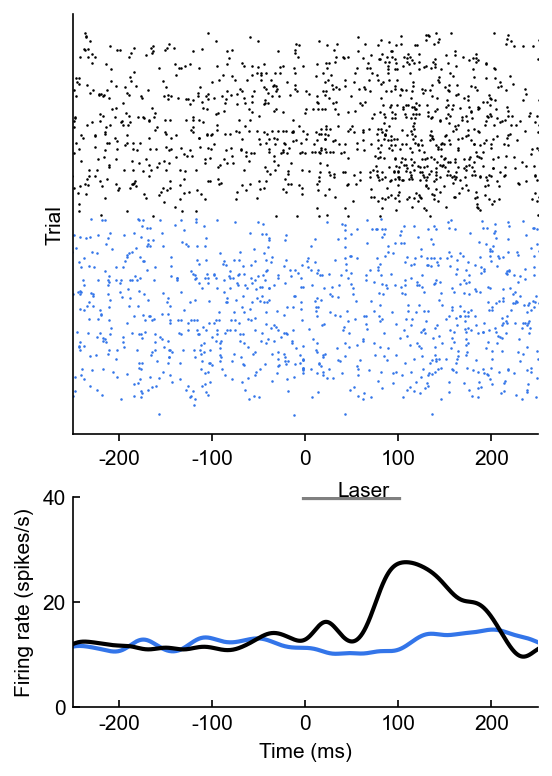

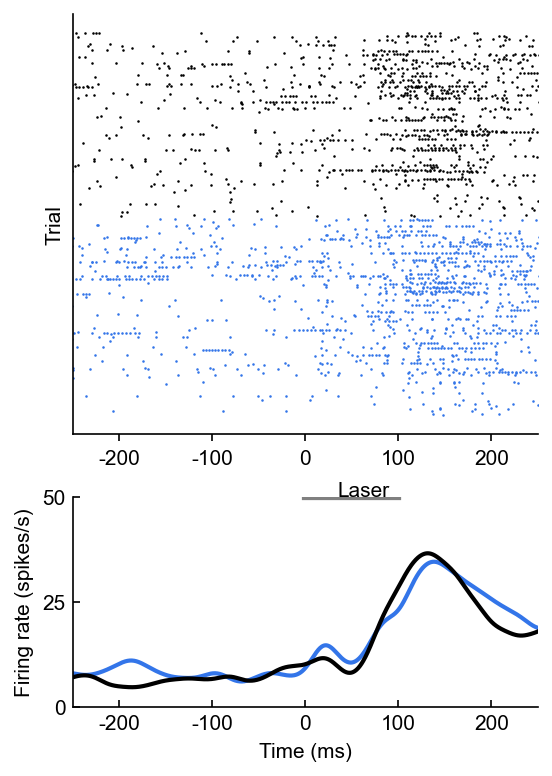

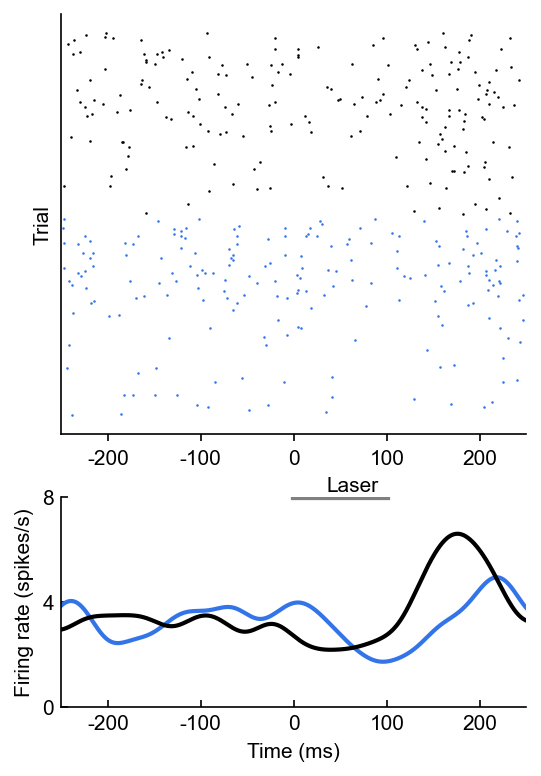

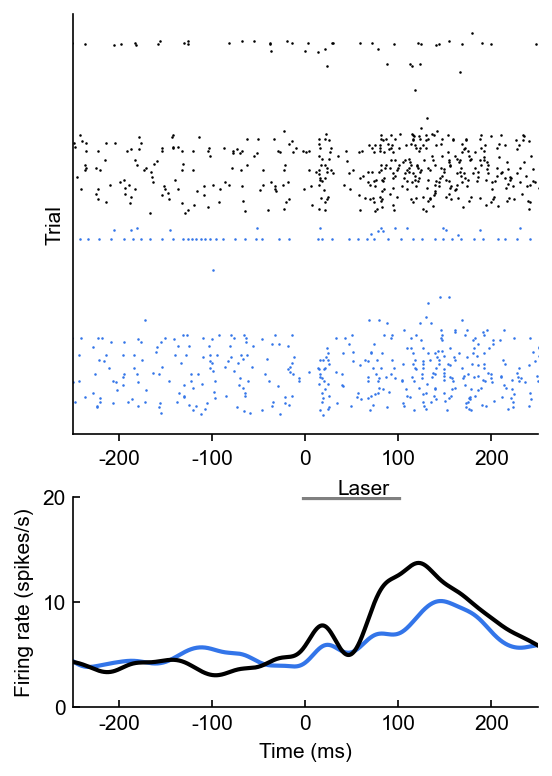

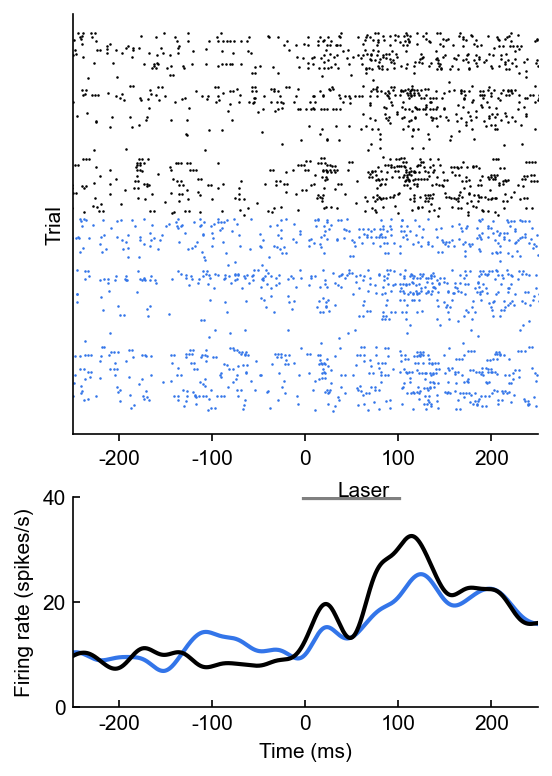

In [122]:
for clust in sessionfile1001.clusters.good:
    visualizeCluster(sessionfile1001,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


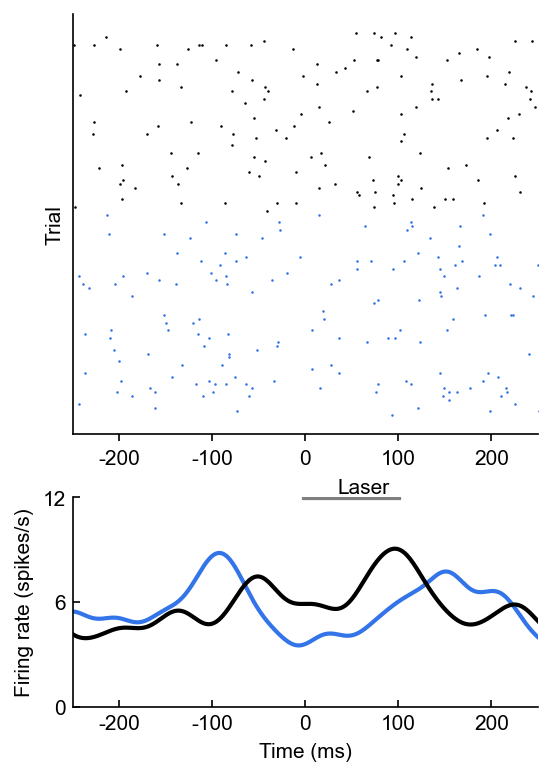

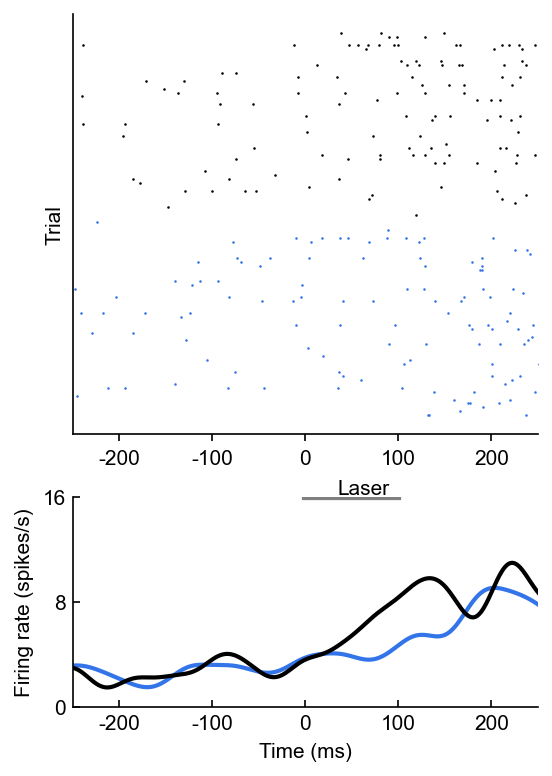

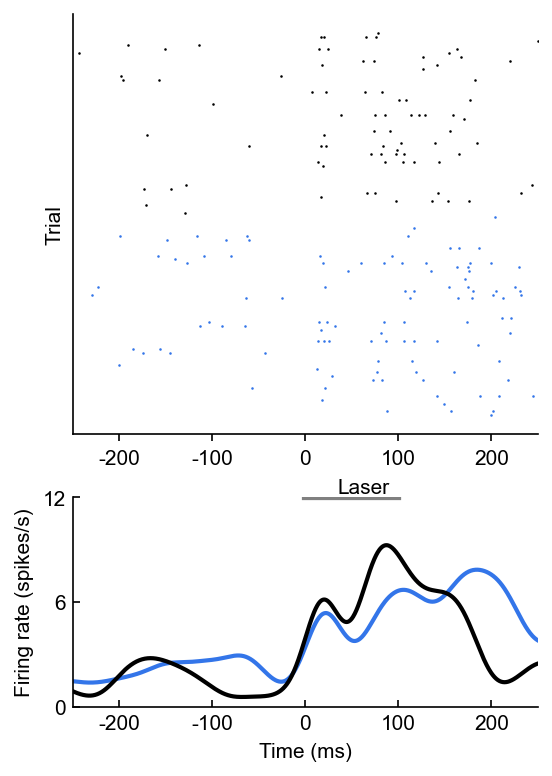

In [124]:
for clust in sessionfile1002.clusters.good:
    visualizeCluster(sessionfile1002,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


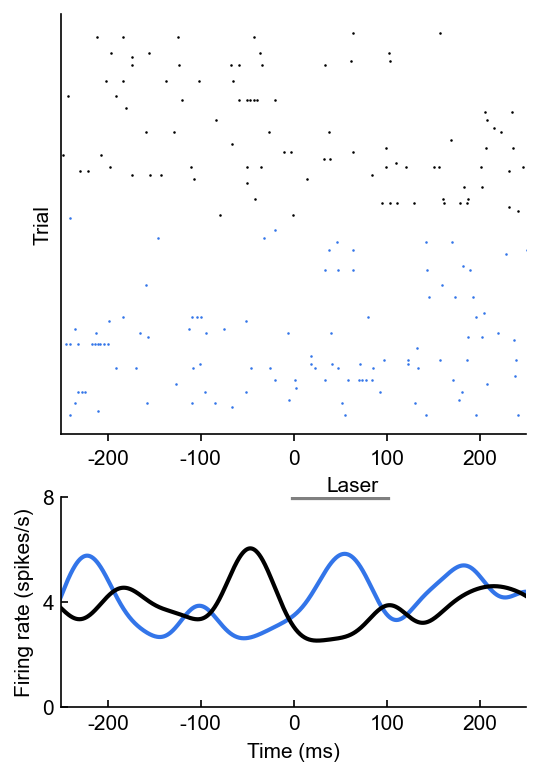

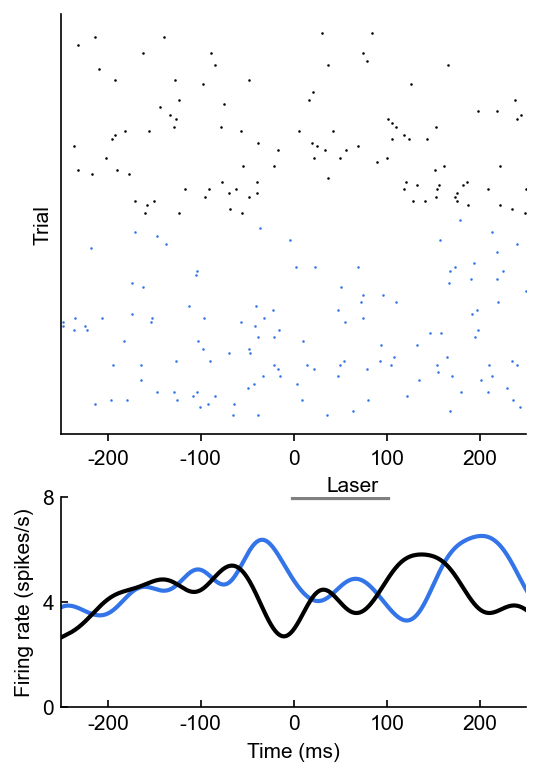

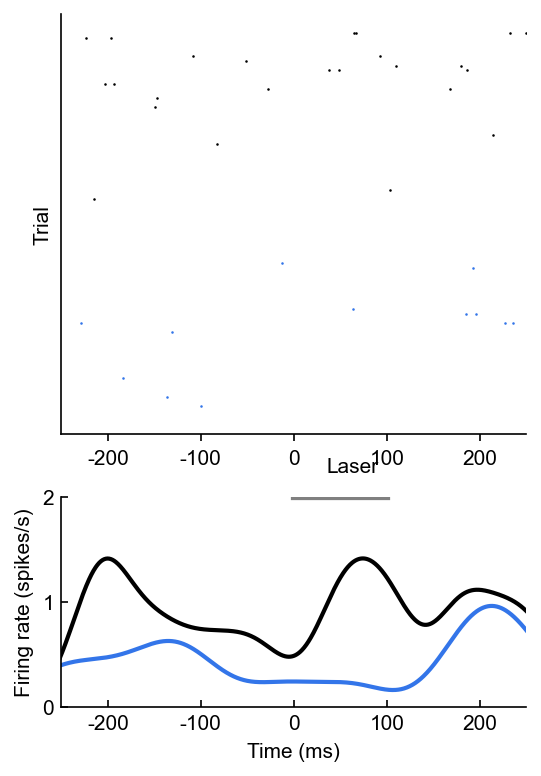

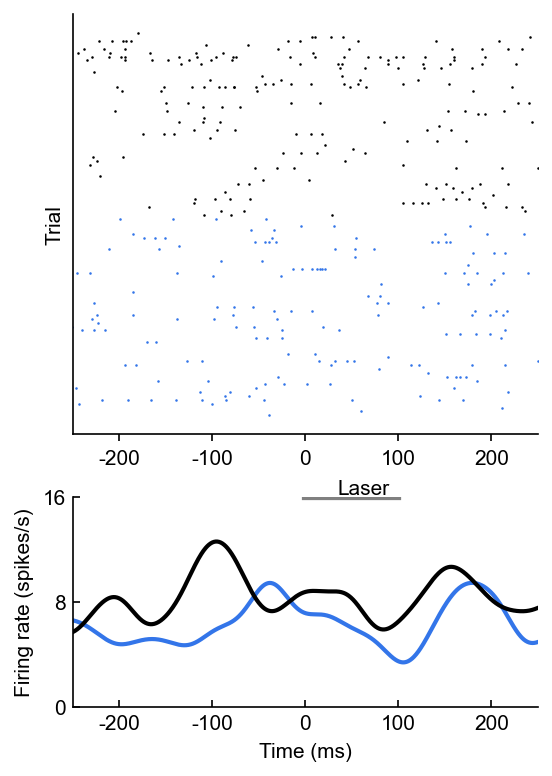

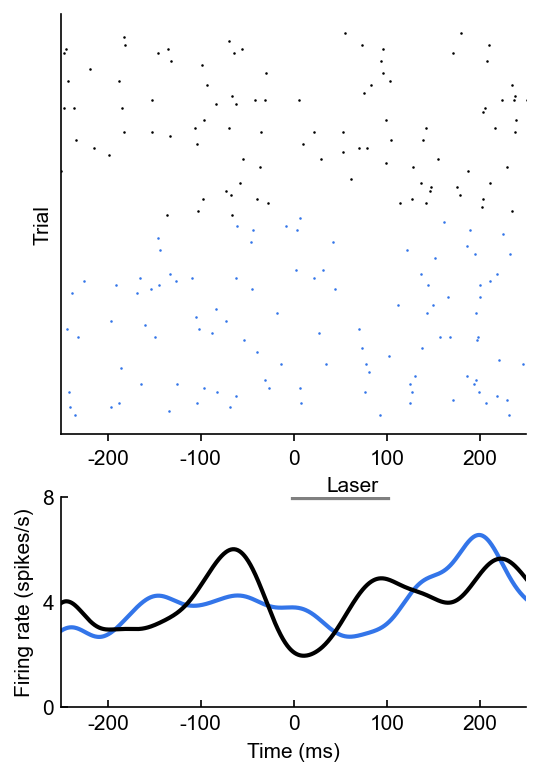

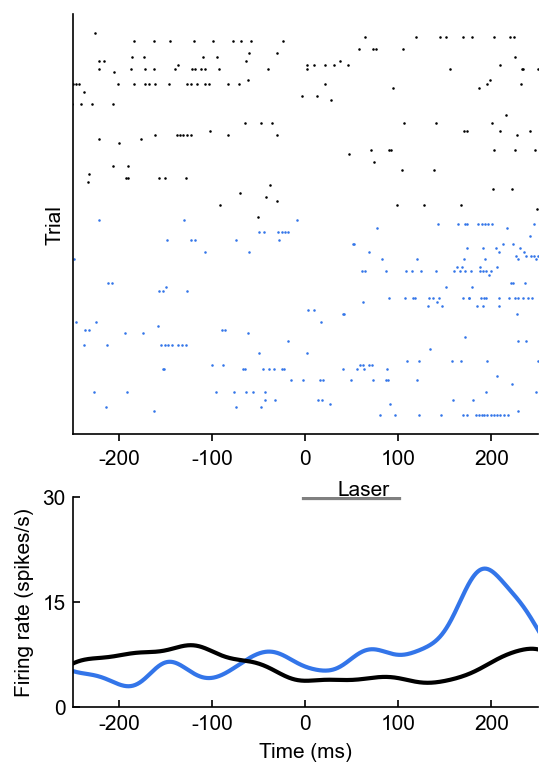

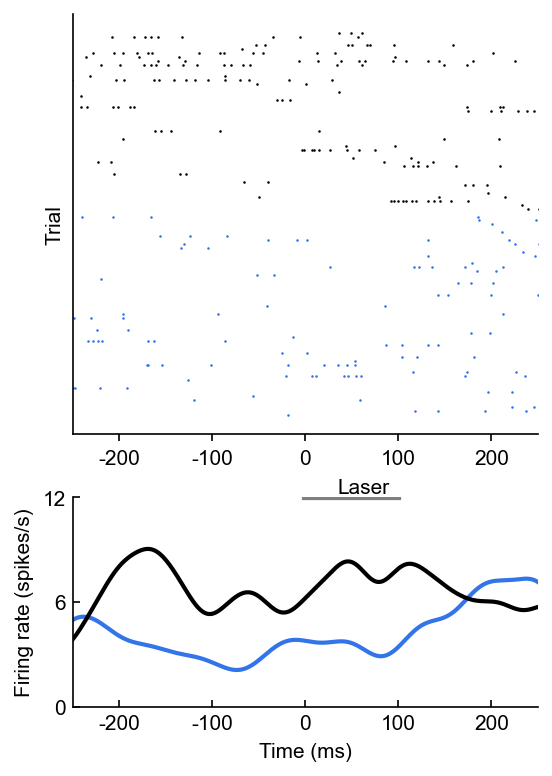

In [126]:
for clust in sessionfile1003.clusters.good:
    visualizeCluster(sessionfile1003,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


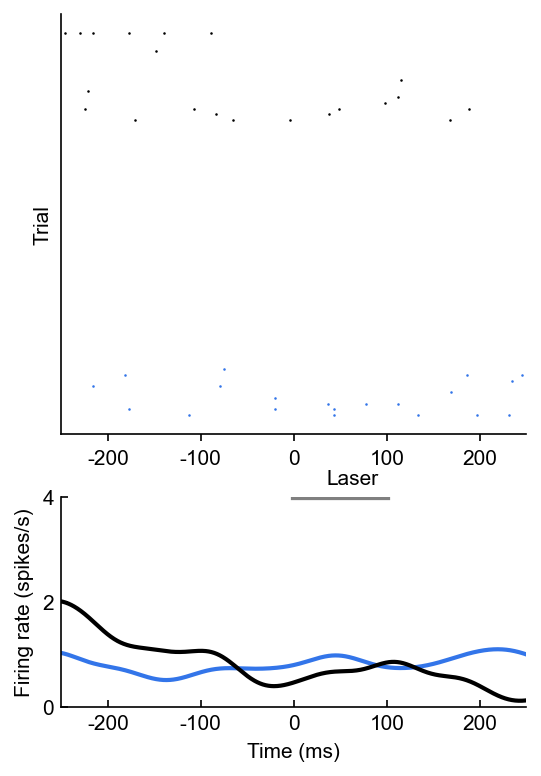

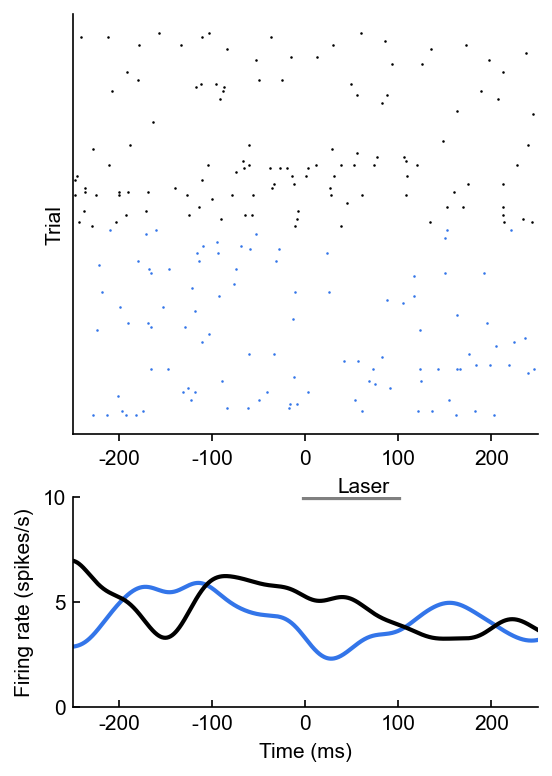

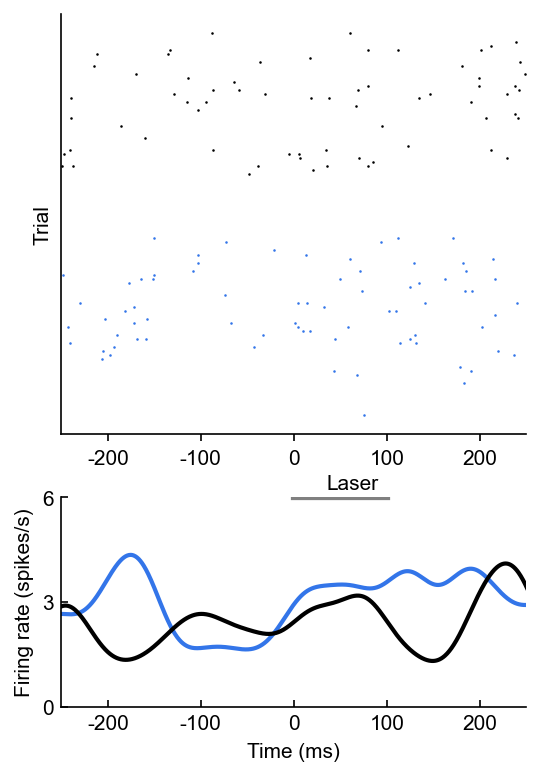

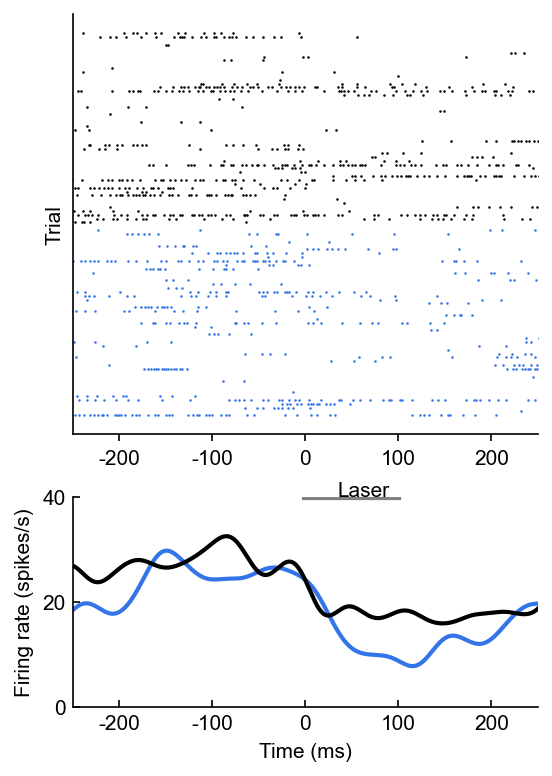

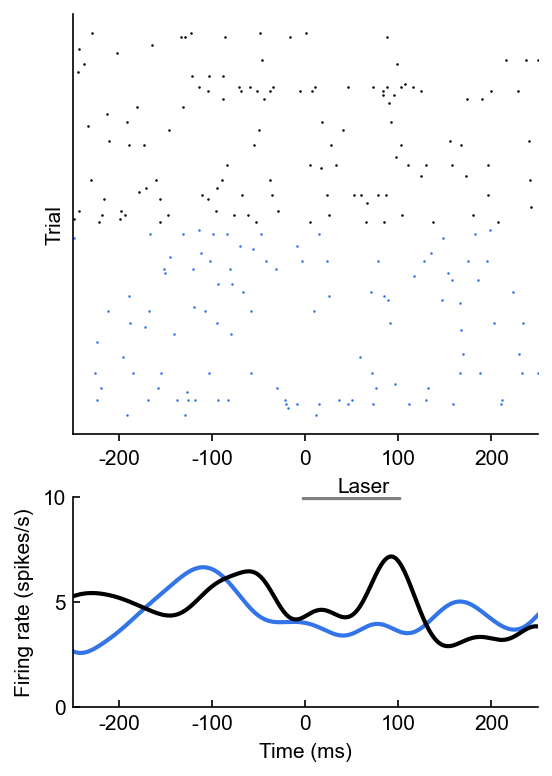

In [128]:
for clust in sessionfile1004.clusters.good:
    visualizeCluster(sessionfile1004,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


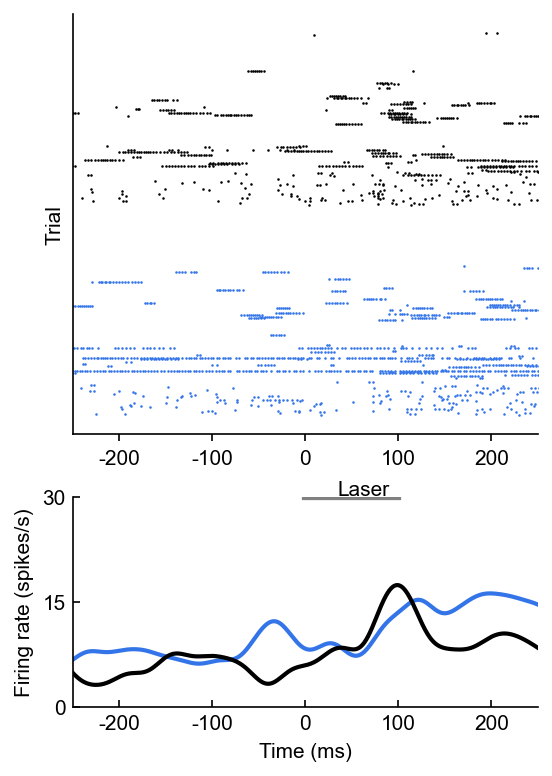

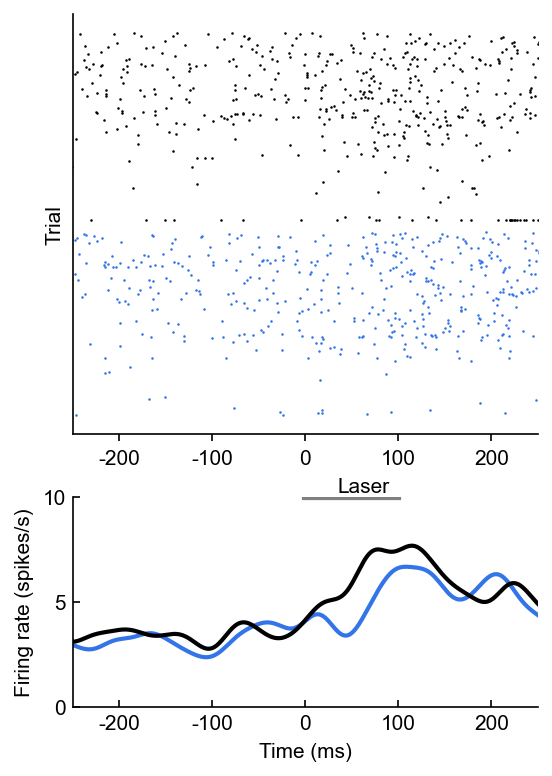

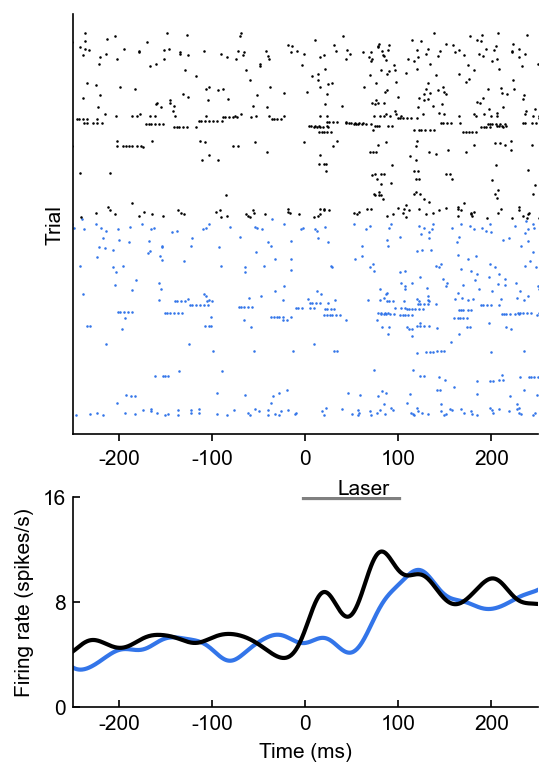

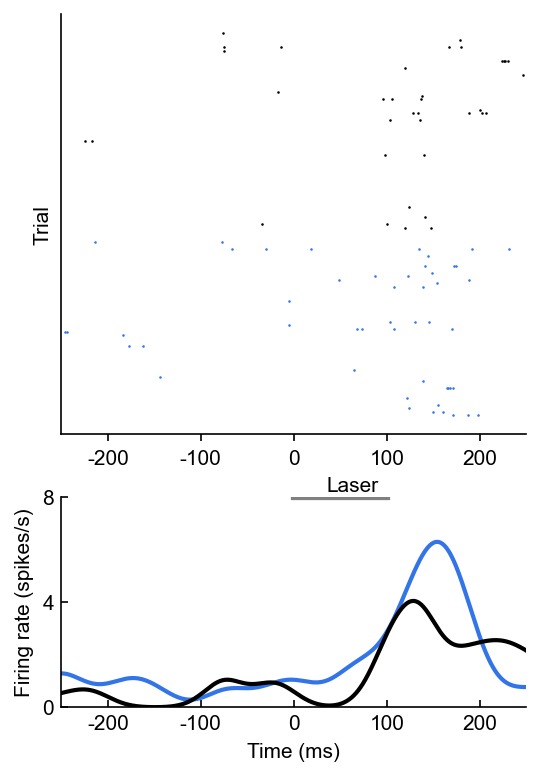

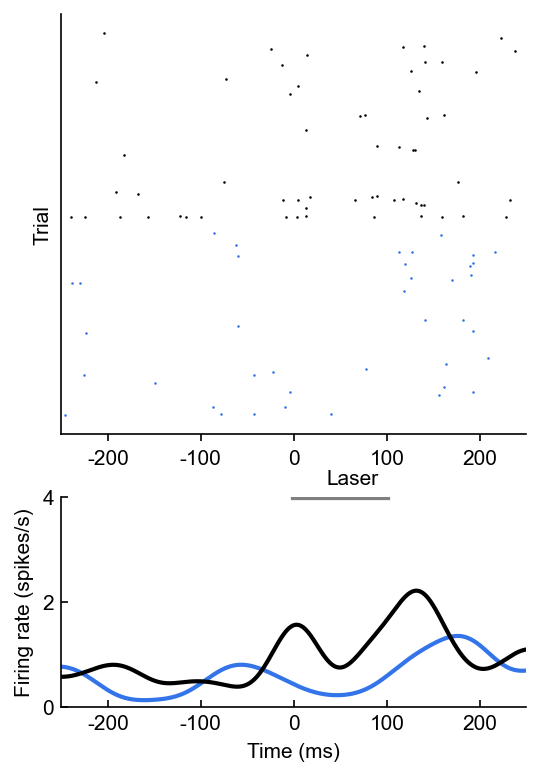

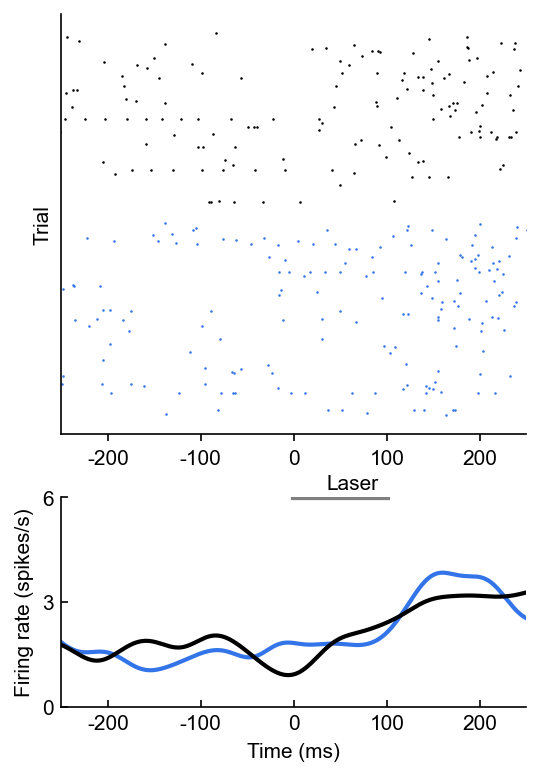

In [130]:
for clust in sessionfile2001.clusters.good:
    visualizeCluster(sessionfile2001,clust)

### Raster with [-250, 250]

In [36]:
def visualizeCluster(sessionfile,clust):

    bw_scott_factor = 3
    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.2)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

    # ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)
    # ax1.get_xaxis().set_visible(False)
    # ax1.get_yaxis().set_visible(False)
    
    tickmeans = []
    ticklabels = []
    ax1.set_ylabel('Trial')

    ax1.set_yticks(tickmeans)
    ax1.set_yticklabels(ticklabels)

    ax1.tick_params(axis='y',length=0)
    ax1.tick_params(axis='x',direction='out')
    ax1.set_xticks([-200,-100,0,100,200])
    #########################################################################################
    
    trialsToPlot_on = sessionfile.responsiveness[clust]['laser_on'].trials
    trialsToPlot_off = sessionfile.responsiveness[clust]['laser_off'].trials
    
    
    trialSpikes_on = []
    trialSpikes_off = []
    

    for trial in trialsToPlot_on:

        #Need to get spike times for each trail...
        starttime = sessionfile.trials.starts[trial]-0.3*sessionfile.meta.fs #-300ms
        endtime = starttime+0.6*sessionfile.meta.fs #-300+600=300ms
        
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - sessionfile.trials.starts[trial]

        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs #spikes in ms
        filtered_trialSpikes =  [n for n in this_trial_spikes if not (-2 <=n <=1 or 97.5 <=n <=101)]
        #filtered_trialSpikes = this_trial_spikes
        trialSpikes_on.append(filtered_trialSpikes)
    trialSpikes_on = np.array(trialSpikes_on,dtype='object')
    
    for trial in trialsToPlot_off:

        #Need to get spike times for each trail...
        starttime = sessionfile.trials.starts[trial]-0.3*sessionfile.meta.fs
        endtime = starttime+0.6*sessionfile.meta.fs
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        this_trial_spikes = this_trial_spikes - sessionfile.trials.starts[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs
        
        trialSpikes_off.append(this_trial_spikes)
    trialSpikes_off = np.array(trialSpikes_off,dtype='object')
     
    #On
    for idx,trial in enumerate(trialsToPlot_on):
        ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=LASER_COLOR,s=1.5,marker='o',lw=0)

    #Off
    ontrials = len(trialsToPlot_on)
    for idx,trial in enumerate(trialsToPlot_off):
        ax1.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx+ontrials,color='black',s=1.5,marker='o',lw=0)

    #Plot PSTH
    starttime = -300
    endtime = 300
    
    #On
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_on)):
        PSTHspikes = np.concatenate(trialSpikes_on[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_on = np.mean(FR,axis=0)
    sem_FR_on = np.std(FR,axis=0)

    #Off
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_off)):
        PSTHspikes = np.concatenate(trialSpikes_off[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_off = np.mean(FR,axis=0)
    sem_FR_off = np.std(FR,axis=0)
    
    max_FR_value_on = np.max(avg_FR_on+sem_FR_on) * 1.1
    max_FR_value_off = np.max(avg_FR_off+sem_FR_off) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    if max_FR_value_on > max_FR_value_off:
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_on)
    else:
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_off)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    
    
    ax2.plot(xrange,avg_FR_on,lw=2,color=LASER_COLOR,label='ON')
    ax2.plot(xrange,avg_FR_off,lw=2,color='black',label='OFF')
    
    #ax2.legend()
    
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    #laser line
    ax2.plot([0,100],[limit,limit],color='gray',lw=3,linestyle='-',zorder=10)
    ax2.text(35,limit+0.24,'Laser')
    ax2.set_xlim([-250,250])
    ax2.set_xticks([-200,-100,0,100,200])
    ax2.set_xticklabels(['-200','-100','0','100','200'])
    ax2.set_xlabel('Time (ms)')
    
    plt.close()
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\test' + str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\test\\S1 opsin'+ str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\test\\S2 opsin'+ str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')

    #print(trialSpikes_on)
    
    return fig#,[ax1,ax2]


In [35]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[0])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


In [37]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[1])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


### do not use

In [123]:
##################################

In [57]:
def visualizeCluster(sessionfile,clust):
    starttime = -250
    endtime = 250
    bw_scott_factor = 3

    buffer = 50
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.2)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

    # ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)
    # ax1.get_xaxis().set_visible(False)
    # ax1.get_yaxis().set_visible(False)
    
    tickmeans = []
    ticklabels = []
    ax1.set_ylabel('Trial')

    ax1.set_yticks(tickmeans)
    ax1.set_yticklabels(ticklabels)

    ax1.tick_params(axis='y',length=0)
    ax1.tick_params(axis='x',direction='out')
    ax1.set_xticks([-200,-100,0,100,200])
    
    
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)

    trialsToPlot_on = sessionfile.responsiveness[clust]['laser_on'].trials
    trialsToPlot_off = sessionfile.responsiveness[clust]['laser_off'].trials
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    trialSpikes_on = []
    trialSpikes_off = []
    
    for trial in trialsToPlot_on:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        #filtered_trialSpikes = [n for n in this_trial_spikes if not (-2 <=n <=1 or 97.5 <=n <=101)]
        filtered_trialSpikes = this_trial_spikes
        trialSpikes_on.append(filtered_trialSpikes)
        
        
    trialSpikes_on = np.array(trialSpikes_on,dtype='object')
    
    for trial in trialsToPlot_off:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        filtered_trialSpikes = this_trial_spikes
        trialSpikes_off.append(filtered_trialSpikes)
        
        
    trialSpikes_off = np.array(trialSpikes_off,dtype='object')
    
    #On
    for idx,trial in enumerate(trialsToPlot_on):
        ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=LASER_COLOR,s=1.5,marker='o',lw=0)

    #Off
    ontrials = len(trialsToPlot_on)
    for idx,trial in enumerate(trialsToPlot_off):
        ax1.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx+ontrials,color='black',s=1.5,marker='o',lw=0)

    #Plot PSTH
    #On
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_on)):
        PSTHspikes = np.concatenate(trialSpikes_on[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_on = np.mean(FR,axis=0)
    sem_FR_on = np.std(FR,axis=0)

    #Off
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_off)):
        PSTHspikes = np.concatenate(trialSpikes_off[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_off = np.mean(FR,axis=0)
    sem_FR_off = np.std(FR,axis=0)
    
    max_FR_value_on = np.max(avg_FR_on+sem_FR_on) * 1.1
    max_FR_value_off = np.max(avg_FR_off+sem_FR_off) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    if max_FR_value_on > max_FR_value_off:
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_on)
    else:
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_off)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    
    ax2.plot(xrange,avg_FR_on,lw=2,color=LASER_COLOR,label='ON')
    ax2.plot(xrange,avg_FR_off,lw=2,color='black',label='OFF')
    #ax2.legend()
    
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    #laser line
    ax2.plot([0,100],[limit,limit],color='gray',lw=3,linestyle='-',zorder=10)
    ax2.text(35,limit+0.24,'Laser')
    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-200,-100,0,100,200])
    ax2.set_xticklabels(['-200','-100','0','100','200'])
    ax2.set_xlabel('Time (ms)')
    
    plt.close()
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\long period\\S1 Opsin_artifact' + str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\long period\\S2 Opsin_artifact' + str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    #print(trialSpikes_on)
    
    return fig#,[ax1,ax2]


In [58]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[0])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


In [56]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[1])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


### Remove laser artifacts and plot

In [138]:
def visualizeCluster(sessionfile,clust):
    starttime = -100
    endtime = 150
    bw_scott_factor = 3

    buffer = 50
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.2)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

    # ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)
    # ax1.get_xaxis().set_visible(False)
    # ax1.get_yaxis().set_visible(False)
    
    tickmeans = []
    ticklabels = []
    ax1.set_ylabel('Trial')

    ax1.set_yticks(tickmeans)
    ax1.set_yticklabels(ticklabels)

    ax1.tick_params(axis='y',length=0)
    ax1.tick_params(axis='x',direction='out')
    ax1.set_xticks([-100,-50,0,50,100,150])
    
    
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)

    trialsToPlot_on = sessionfile.responsiveness[clust]['laser_on'].trials
    trialsToPlot_off = sessionfile.responsiveness[clust]['laser_off'].trials
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    trialSpikes_on = []
    trialSpikes_off = []
    
    for trial in trialsToPlot_on:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        filtered_trialSpikes = [n for n in this_trial_spikes if not (-2 <=n <=1 or 97.5 <=n <=101)]
        trialSpikes_on.append(filtered_trialSpikes)
        
        
    trialSpikes_on = np.array(trialSpikes_on,dtype='object')
    
    for trial in trialsToPlot_off:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        filtered_trialSpikes = this_trial_spikes
        trialSpikes_off.append(filtered_trialSpikes)
        
        
    trialSpikes_off = np.array(trialSpikes_off,dtype='object')
    
    #On
    for idx,trial in enumerate(trialsToPlot_on):
        ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=LASER_COLOR,s=1.5,marker='o',lw=0)

    #Off
    ontrials = len(trialsToPlot_on)
    for idx,trial in enumerate(trialsToPlot_off):
        ax1.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx+ontrials,color='black',s=1.5,marker='o',lw=0)

    #Plot PSTH
    #On
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_on)):
        PSTHspikes = np.concatenate(trialSpikes_on[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_on = np.mean(FR,axis=0)
    sem_FR_on = np.std(FR,axis=0)

    #Off
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_off)):
        PSTHspikes = np.concatenate(trialSpikes_off[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_off = np.mean(FR,axis=0)
    sem_FR_off = np.std(FR,axis=0)
    
    max_FR_value_on = np.max(avg_FR_on+sem_FR_on) * 1.1
    max_FR_value_off = np.max(avg_FR_off+sem_FR_off) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    if max_FR_value_on > max_FR_value_off:
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_on)
    else:
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_off)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    
    ax2.plot(xrange,avg_FR_on,lw=2,color=LASER_COLOR,label='ON')
    ax2.plot(xrange,avg_FR_off,lw=2,color='black',label='OFF')
    #ax2.legend()
    
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    #laser line
    ax2.plot([0,100],[limit,limit],color='gray',lw=3,linestyle='-',zorder=10)
    ax2.text(35,limit+0.24,'Tone')
    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-100,-50,0,50,100,150])
    ax2.set_xticklabels(['-100','-50','0','50','100','150'])
    ax2.set_xlabel('Time (ms)')
    
    plt.close()
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\S1 Opsin' + str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\S2 Opsin' + str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    #print(trialSpikes_on)
    
    return fig#,[ax1,ax2]



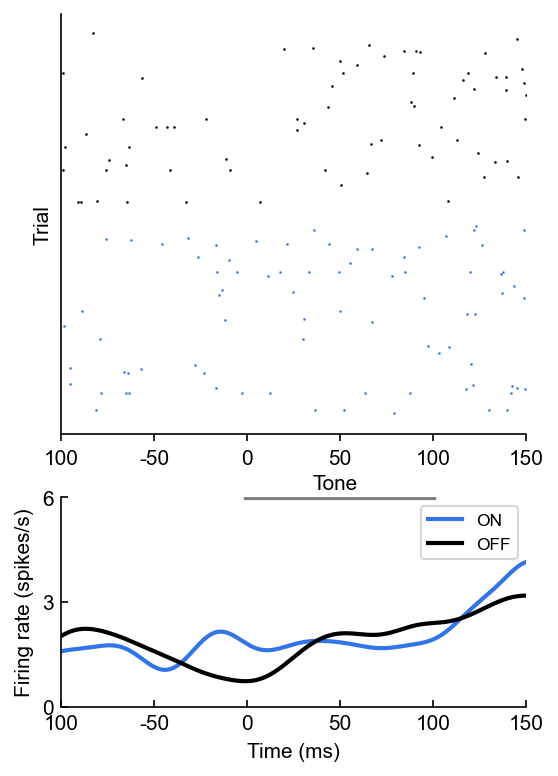

In [98]:
visualizeCluster(sessionfile,clust)

In [137]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[0])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


In [139]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[1])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


### OLD

In [45]:
def visualizeCluster(sessionfile,clust):
    starttime = -50
    endtime = 150
    bw_scott_factor = 3

    buffer = 50
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.2)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

    # ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)
    # ax1.get_xaxis().set_visible(False)
    # ax1.get_yaxis().set_visible(False)
    
    tickmeans = []
    ticklabels = []
    ax1.set_ylabel('Trial')

    ax1.set_yticks(tickmeans)
    ax1.set_yticklabels(ticklabels)

    ax1.tick_params(axis='y',length=0)
    ax1.tick_params(axis='x',direction='out')
    ax1.set_xticks([-50,0,50,100,150])
    
    
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)

    trialsToPlot_on = sessionfile.responsiveness[clust]['laser_on'].trials
    trialsToPlot_off = sessionfile.responsiveness[clust]['laser_off'].trials
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    trialSpikes_on = []
    trialSpikes_off = []
    
    for trial in trialsToPlot_on:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes_on.append(this_trial_spikes)
    trialSpikes_on = np.array(trialSpikes_on,dtype='object')
    for trial in trialsToPlot_off:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes_off.append(this_trial_spikes)
    trialSpikes_off = np.array(trialSpikes_off,dtype='object')
    
    #On
    for idx,trial in enumerate(trialsToPlot_on):
        ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=LASER_COLOR,s=1.5,marker='o',lw=0)

    #Off
    ontrials = len(trialsToPlot_on)
    for idx,trial in enumerate(trialsToPlot_off):
        ax1.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx+ontrials,color='black',s=1.5,marker='o',lw=0)

    #Plot PSTH
    #On
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_on)):
        PSTHspikes = np.concatenate(trialSpikes_on[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_on = np.mean(FR,axis=0)
    sem_FR_on = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR_on,lw=2,color=LASER_COLOR,label='ON')
    
    max_FR_value_on = np.max(avg_FR_on+sem_FR_on) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_on)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    #laser line
    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-50,0,50,100,150])
    ax2.set_xticklabels(['-50','0','50','100','150'])
    ax2.set_xlabel('Time (ms)')

    #Off
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_off)):
        PSTHspikes = np.concatenate(trialSpikes_off[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_off = np.mean(FR,axis=0)
    sem_FR_off = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR_off,lw=2,color='black',label='OFF')
    ax2.legend()
    
    plt.close()
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\S1 Opsin' + str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\OpsinTest\\S2 Opsin' + str(clust)+'.pdf'),transparent=False,facecolor="white", bbox_inches='tight')
    
    print(trialSpikes_on)
    return fig#,[ax1,ax2]




[array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([163.8]) array([-1.26666667])
 array([78.86666667]) array([], dtype=float64)
 array([-81.43333333,  36.46666667,  51.76666667, 129.83333333,
        139.9       , 170.96666667, 172.96666667])
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64) array([-1.4])
 array([], dtype=float64) array([], dtype=float64) array([-1.4])
 array([], dtype=float64) array([], dtype=float64) array([-1.13333333])
 array([], dtype=float64)
 array([-78.46666667, -65.43333333, -63.56666667,  -2.66666667,
         12.26666667,  63.13333333,  87.73333333, 141.86666667,
        197.93333333])
 array([ -1.26666667, 157.8       ]) array([], dtype=float64)
 array([117.86666667, 149.3  

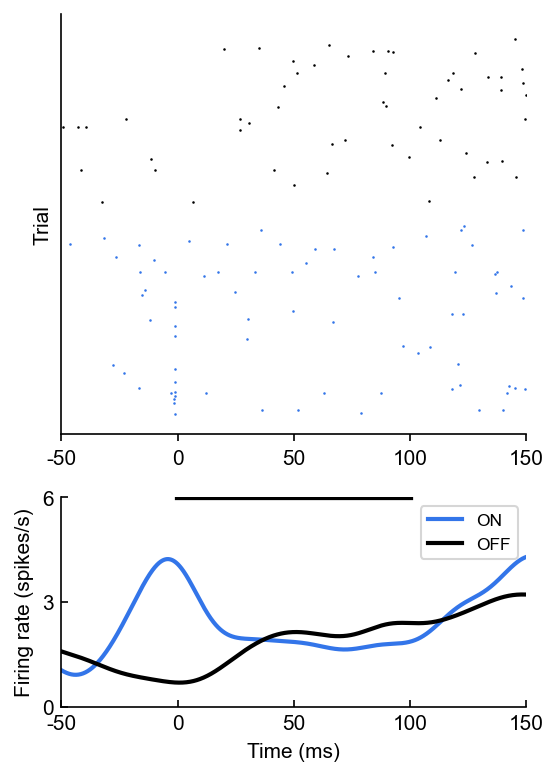

In [46]:
visualizeCluster(sessionfile,clust)

In [266]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[0])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


In [268]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[1])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


In [186]:
############################

In [203]:
def visualizeCluster(sessionfile,clust):
    starttime = -0.05
    endtime = 0.15
    numbins = 100 + 1

    height=10
    width=1
    trans=0.125
    custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)

    conditions = []

    condition = SimpleNamespace()
    laser_on = sessionfile.trials.laser_stimulation
    laser_on = np.array(np.where(laser_on)[0])
    laser_on = laser_on[np.isin(laser_on,sessionfile.trim[clust].trimmed_trials)]
    condition.trials = laser_on
    condition.label = 'ON'
    condition.color = LASER_COLOR
    conditions.append(condition)

    condition = SimpleNamespace()
    laser_off = np.logical_not(sessionfile.trials.laser_stimulation)
    laser_off = np.array(np.where(laser_off)[0])
    laser_off = laser_off[np.isin(laser_off,sessionfile.trim[clust].trimmed_trials)]

    condition.trials = laser_off
    condition.label = 'OFF'
    condition.color = 'k'
    conditions.append(condition)

    totaltrials = 0
    for cond in conditions:
        totaltrials += len(cond.trials)

    idx = np.equal(sessionfile.spikes.clusters,clust)
    totaltimes = sessionfile.spikes.times[idx]

    for cond in conditions:
        cond.timestoplot = []
        cond.trialstoplot = []

    for trialidx,trial in enumerate(cond.trials):
        trialstart = sessionfile.trials.starts[trial]

        #Caching search -- Condition
        idx = np.logical_and(np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
        times = totaltimes[idx]

        #Each spike time to plot
        for spike in ((times-trialstart)/sessionfile.meta.fs*1000):
            cond.timestoplot.append(spike)
            cond.trialstoplot.append(trialidx+1)
    #############################################---PLOTTING---#############################################

    plt.close('all')
    fig,ax = plt.subplots(figsize=(5,3))

    #Plot Rasters
    offset = 0
    tickmeans = []
    ticklabels = []
    numtrials = 0
    for cond in conditions:
        ax.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
        
        if cond.label == 'ON':
            starttrial = offset
            endtrial = offset+len(cond.trials)

        tickmeans.append(0.5*len(cond.trials)+offset)
        
        offset += len(cond.trials)
        ticklabels.append(cond.label)
        numtrials += len(cond.trials)
    ylims1 = [1,numtrials]
    ax.set_ylim(ylims1)
    ax.set_yticks(tickmeans)
    ax.set_yticklabels(ticklabels)

    ax.tick_params(axis='y',length=0)
    colors = [cond.color for cond in conditions]
    [t.set_color(colors[idx]) for idx,t in enumerate(ax.yaxis.get_ticklabels())]

    ax.tick_params(axis='x',direction='out')
    ax.set_xticks([-50,0,50,100,150])

    ax.set_ylabel('Trial')
    ax.set_xlabel('Time (ms)')
    xlimsfromrasters = ax.get_xlim()
    
 
    return fig

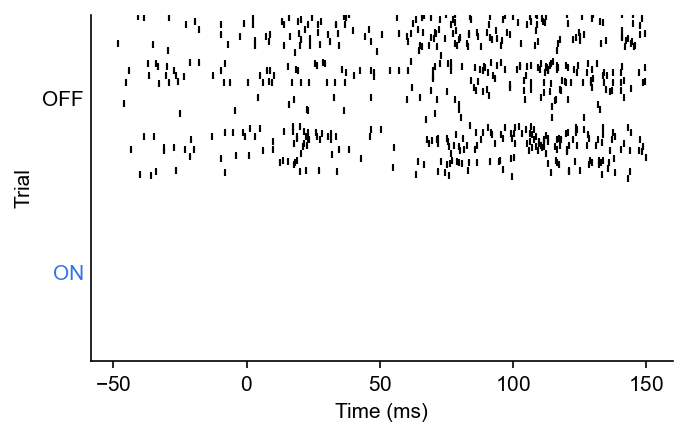

In [204]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[0])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)
    

In [159]:
def visualizeCluster(sessionfile,clust):
    starttime = -0.05
    endtime = 0.15
    numbins = 100 + 1

    height=10
    width=1
    trans=0.125
    custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)

    conditions = []

    condition = SimpleNamespace()
    laser_on = sessionfile.trials.laser_stimulation
    laser_on = np.array(np.where(laser_on)[0])
    laser_on = laser_on[np.isin(laser_on,sessionfile.trim[clust].trimmed_trials)]
    condition.trials = laser_on
    condition.label = 'ON'
    condition.color = LASER_COLOR
    conditions.append(condition)

    condition = SimpleNamespace()
    laser_off = np.logical_not(sessionfile.trials.laser_stimulation)
    laser_off = np.array(np.where(laser_off)[0])
    laser_off = laser_off[np.isin(laser_off,sessionfile.trim[clust].trimmed_trials)]

    condition.trials = laser_off
    condition.label = 'OFF'
    condition.color = 'k'
    conditions.append(condition)

    totaltrials = 0
    for cond in conditions:
        totaltrials += len(cond.trials)

    idx = np.equal(sessionfile.spikes.clusters,clust)
    totaltimes = sessionfile.spikes.times[idx]

    for cond in conditions:
        cond.timestoplot = []
        cond.trialstoplot = []
        cond.peristimulustimes = []

        for trialidx,trial in enumerate(cond.trials):
            trialstart = sessionfile.trials.starts[trial]

            #Caching search -- Condition
            idx = np.logical_and(np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs-0.25*30000) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs+0.25*30000)     )
            times = totaltimes[idx]

            #PSTH times
            cond.peristimulustimes = np.concatenate((cond.peristimulustimes,(times-trialstart)/sessionfile.meta.fs*1000))
    #############################################---PLOTTING---#############################################

    plt.close('all')
    fig,ax = plt.subplots(figsize=(5,3))

    #Plot PSTHs
    bw=0.05
    xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
    ind = 0
    max_FR = -np.inf
    for cond in conditions:
        try:
            KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
            FR = KDE*len(cond.peristimulustimes) / len(cond.trials) * 1000
            targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
            ax.plot(xrange,FR,c=cond.color,lw=2)

            max_FR = max(max_FR,np.max(FR))
        except Exception as e:
            print('PSTHs: '+str(e))
        ind = ind + 1

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing rate (spikes/s)')
    ax.tick_params(axis='x',direction='out')
    ax.set_xticks([-50,0,50,100,150])

    #ax.set_xlim(-50,200)


    max_FR_value = max_FR * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax.set_ylim([0,limit])
    ax.set_yticks([0,limit/2,limit])
    ax.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    
    return fig


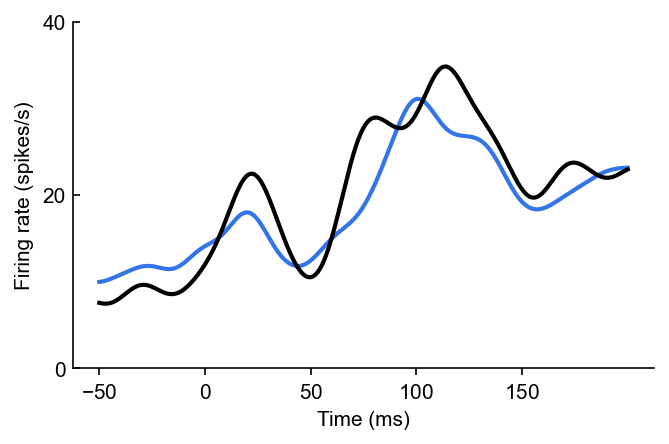

In [160]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[0])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)
    


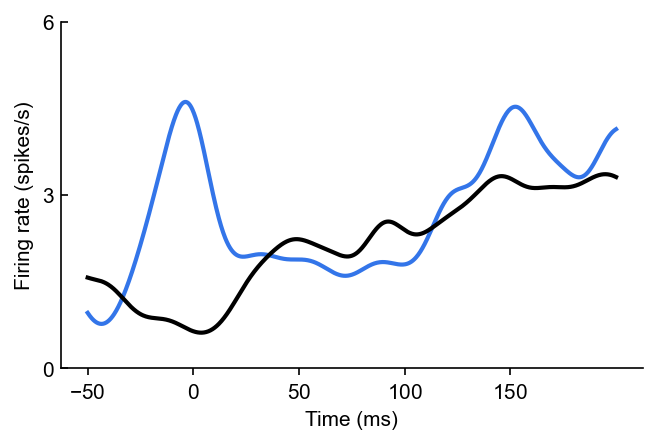

In [161]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[1])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)
    

In [127]:
############################

In [90]:
def visualizeCluster(sessionfile,clust):

    starttime = -250
    endtime = 1500
    bw_scott_factor = 3

    buffer = 500
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(8,6))
    gs = fig.add_gridspec(2,2,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    
    ax3 = plt.subplot(gs[0,1])#Raster
    ax4 = plt.subplot(gs[1,1],sharex=ax1)#PSTH
    
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)

    trialsToPlot_on = sessionfile.responsiveness[clust]['laser_on'].trials
    trialsToPlot_off = sessionfile.responsiveness[clust]['laser_off'].trials
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    trialSpikes_on = []
    trialSpikes_off = []
    
    for trial in trialsToPlot_on:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes_on.append(this_trial_spikes)
    trialSpikes_on = np.array(trialSpikes_on,dtype='object')

    for trial in trialsToPlot_off:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes_off.append(this_trial_spikes)
    trialSpikes_off = np.array(trialSpikes_off,dtype='object')

    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot_on):
        ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
        
    for idx,trial in enumerate(trialsToPlot_off):
        ax3.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)



    #Plot PSTH
    #On
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_on)):
        PSTHspikes = np.concatenate(trialSpikes_on[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_on = np.mean(FR,axis=0)
    sem_FR_on = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR_on,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR_on-sem_FR_on,avg_FR_on+sem_FR_on,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)

    max_FR_value_on = np.max(avg_FR_on+sem_FR_on) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_on)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')

    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([0,500,1000,1500])
    ax2.set_xticklabels(['0','0.5','1','1.5'])
    ax2.set_xlabel('Time (s)')

    #Off
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_off)):
        PSTHspikes = np.concatenate(trialSpikes_off[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_off = np.mean(FR,axis=0)
    sem_FR_off = np.std(FR,axis=0)

    ax4.plot(xrange,avg_FR_off,lw=1,color=FRmod_color)
    ax4.fill_between(xrange,avg_FR_off-sem_FR_off,avg_FR_off+sem_FR_off,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)

    max_FR_value_off = np.max(avg_FR_off+sem_FR_off) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_off)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax4.set_ylim([0,limit])
    ax4.set_yticks([0,limit/2,limit])
    ax4.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax4.set_ylabel('Firing rate (spikes/s)')

    ax4.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax4.set_xlim([starttime,endtime])
    ax4.set_xticks([0,500,1000,1500])
    ax4.set_xticklabels(['0','0.5','1','1.5'])
    ax4.set_xlabel('Time (s)')
    
    
    return fig,[ax1,ax2]





In [91]:
sessionfile.clusters.good

array([ 90, 104, 107, 124, 160, 167], dtype=int64)

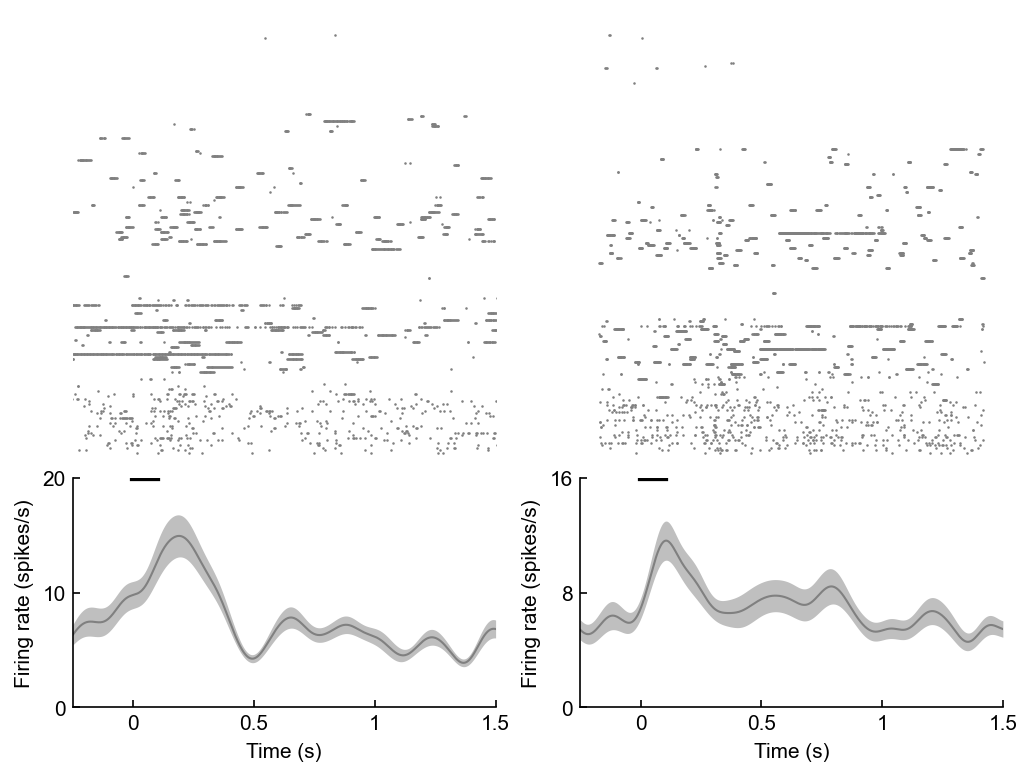

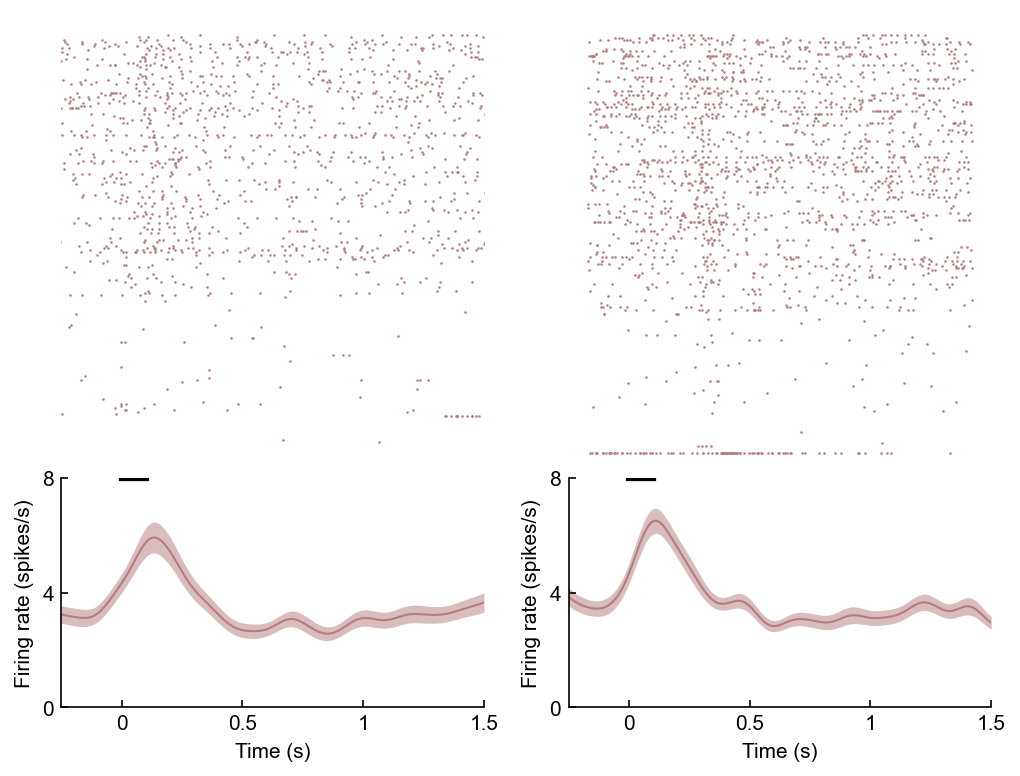

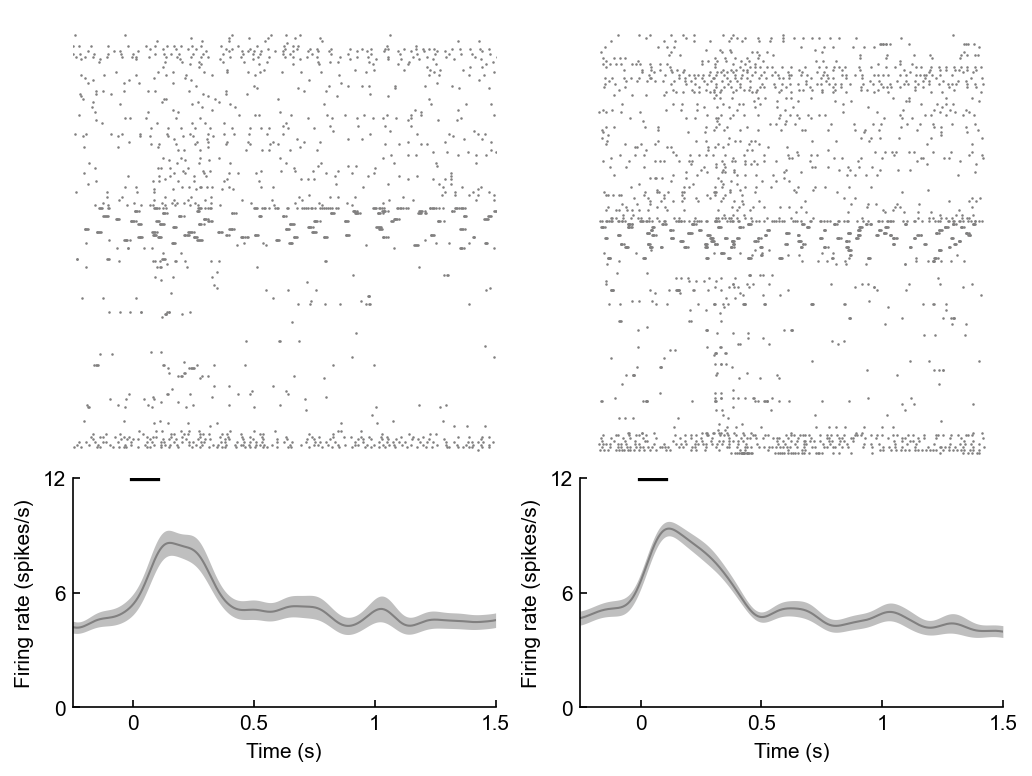

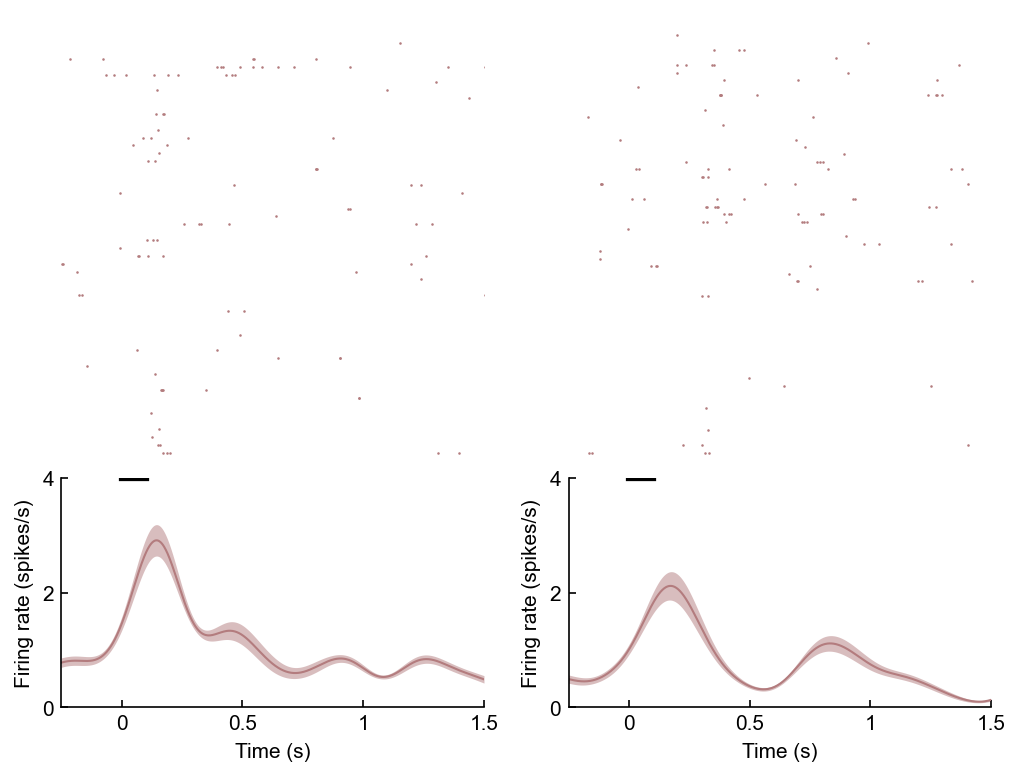

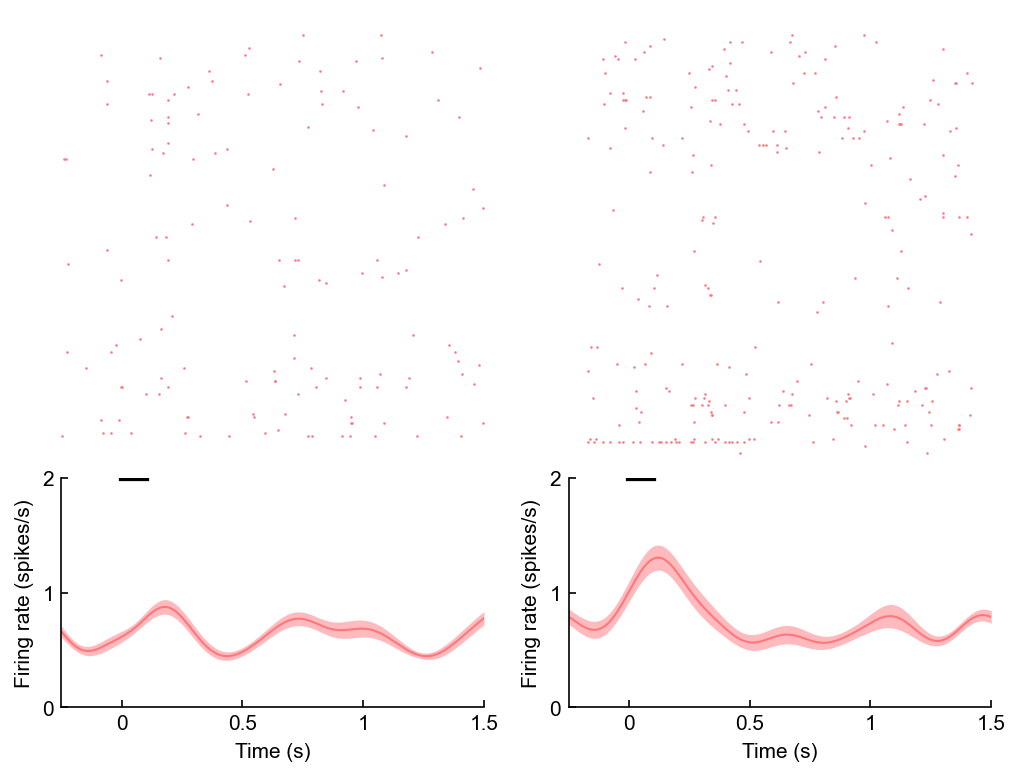

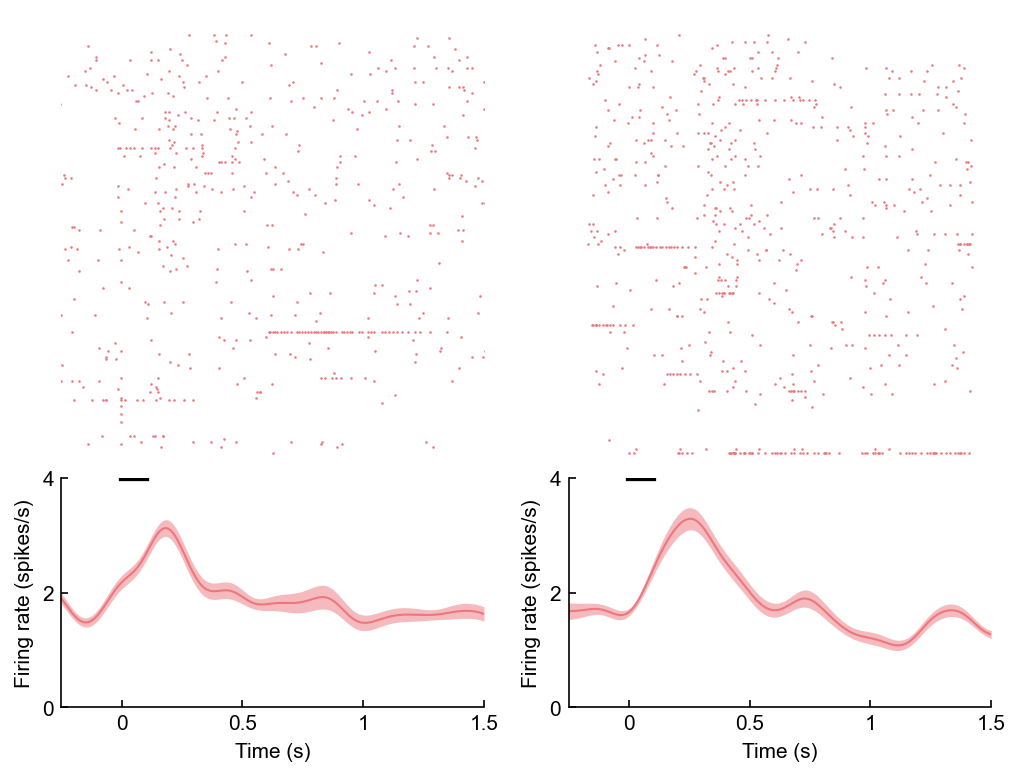

In [92]:
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)